## **This notebook aims to combine multiple assets databases**

In [1]:
import pandas as pd
import numpy as np
import os
import time
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v3"
os.chdir(project_dir)

clean_data_dir = os.path.join(project_dir, "00_data/clean")
horizontal_data_dir = os.path.join(project_dir, "00_data/horizontal_structure")
results_dir = os.path.join(project_dir, "02_results")
plots_dir = os.path.join(project_dir, "03_plots")
pca_data_dir = os.path.join(project_dir, "00_data/pca")

### **GRU Model**

In [3]:
class GRU3DClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRU3DClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        # return self.sigmoid(out)
        return out

### **LSTM Model**

In [4]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
    
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size dynamically

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out
    

### **Set folders**

In [5]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
thresholds = [0.5]
learning_rates = [0.005, 0.008, 0.009, 0.01]
learning_rates = [0.01]
num_epochs_list = [100, 200]
num_epochs_list = [100]
batch_sizes = [16, 32]
batch_sizes = [32]

#### **Model and Hyperparameters**

#### **Last data modifications**

In [6]:
def reshape_remove_characters(df):

    X = np.array([np.stack(row) for row in df.drop(columns=['Target']).values])
    y = df['Target'].values

    smote = SMOTE(random_state=42)
    n_samples, timesteps, n_features = X.shape
    X_flat = X.reshape((n_samples, timesteps * n_features))
    X_flat = np.where(X_flat == 'ç', 0, X_flat)

    X_resampled = X_flat.reshape((-1, timesteps, n_features))
    
    return X_resampled, y

### **Evaluation function**

In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_plot(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    # ---------------------------------------------
    # 1) SINGLE TRAINING PHASE + Track Loss Curves
    # ---------------------------------------------
    model.to(device)
    model.train()

    epoch_train_losses = []
    epoch_test_losses = []

    for epoch in range(num_epochs):
        # TRAINING PASS
        epoch_loss = 0.0
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()

            # Forward
            pred_y = model(X_batch)
            loss = criterion(pred_y, y_batch)

            # Backprop & update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        
        # VALIDATION PASS (Optional but needed to get test_loss_curve)
        if valloader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in valloader:
                    pred_yb = model(Xb)
                    loss_b = criterion(pred_yb, yb)
                    val_loss += loss_b.item()
            avg_val_loss = val_loss / len(valloader)
            epoch_test_losses.append(avg_val_loss)

            model.train()  # Switch back to train mode

        else:
            # If no validation set, just store None or 0
            epoch_test_losses.append(None)

        # Print progress every 5 epochs or last epoch
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            if epoch_test_losses[-1] is not None:
                print(f"[Epoch {epoch+1}/{num_epochs}] ",
                      f"Train Loss: {avg_train_loss:.4f}")
            else:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}")

    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        if any(x is not None for x in epoch_test_losses):
            plt.plot(epoch_test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        # plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses,
        "test_loss_curve": epoch_test_losses
    }


### **Execute evaluation funcion**

In [8]:
def combine_stocks_pkl_df(processing, security_type, period, window_size, project_dir, stocks):

    X_list = []
    y_list = []

    for stock in stocks:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)

        # Store in lists
        X_list.append(X_resampled)
        y_list.append(y_resampled)

    # Concatenate all stocks along the sample dimension
    X_combined = np.concatenate(X_list, axis=0)  # Shape: (total_samples, num_features, window_size)
    y_combined = np.concatenate(y_list, axis=0)  # Shape: (total_samples,)

    # Print shapes to verify
    print("Final X shape:", X_combined.shape)
    print("Final y shape:", y_combined.shape)
    
    return X_combined, y_combined
    

In [9]:
def combine_stocks_pkl_new_df(processing, security_type, period, window_size, project_dir, stocks, test_size):

    X_list = []
    y_list = []
    last_stock = stocks[-1]

    for stock in stocks:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)
        
        # 4) Remove last rows only if not last stock
        if stock!= last_stock:
            X_resampled = X_resampled[:-test_size]
            y_resampled = y_resampled[:-test_size]

        # Store in lists
        X_list.append(X_resampled)
        y_list.append(y_resampled)

    # Concatenate all stocks along the sample dimension
    X_combined = np.concatenate(X_list, axis=0)  # Shape: (total_samples, num_features, window_size)
    y_combined = np.concatenate(y_list, axis=0)  # Shape: (total_samples,)

    # Print shapes to verify
    print("Final X shape:", X_combined.shape)
    print("Final y shape:", y_combined.shape)
    
    return X_combined, y_combined

## **Apply concatenation to specified datasets**

In [10]:
processing = "clean"
security_type = "options"
period = "10y"
stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'SPX']
# window_size = 50

# X_combined, y_combined = combine_stocks_pkl_df(processing, security_type, period, window_size, project_dir, stocks)

## **Run LSTM and GRU Models**

In [11]:
possible_train_size = 95

num_epochs = 100
learning_rate = 0.01
prediction_threshold = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
hidden_size = 64  
output_size = 2  
num_layers = 2
dropout = 0.2

criterion = nn.CrossEntropyLoss()

----- Appending stock: AAPL, period: 10y, data_type: options -----
----- Appending stock: MSFT, period: 10y, data_type: options -----
----- Appending stock: AMZN, period: 10y, data_type: options -----
----- Appending stock: NVDA, period: 10y, data_type: options -----
----- Appending stock: SPX, period: 10y, data_type: options -----
Final X shape: (11830, 11, 5)
Final y shape: (11830,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6971
[Epoch 10/100]  Train Loss: 0.6926
[Epoch 15/100]  Train Loss: 0.6914
[Epoch 20/100]  Train Loss: 0.6897
[Epoch 25/100]  Train Loss: 0.6888
[Epoch 30/100]  Train Loss: 0.6893
[Epoch 35/100]  Train Loss: 0.6872
[Epoch 40/100]  Train Loss: 0.6857
[Epoch 45/100]  Train Loss: 0.6875
[Epoch 50/100]  Train Loss: 0.6889
[Epoch 55/100]  Train Loss: 0.6860
[Epoch 60/100]  Train Loss: 0.6858
[Epoch 65/100]  Train Loss: 0.6844
[Epoch 70/100]  Train Loss: 0.6851
[Epoch 75/100]  Train Loss: 0.6830
[Epoch 80/100

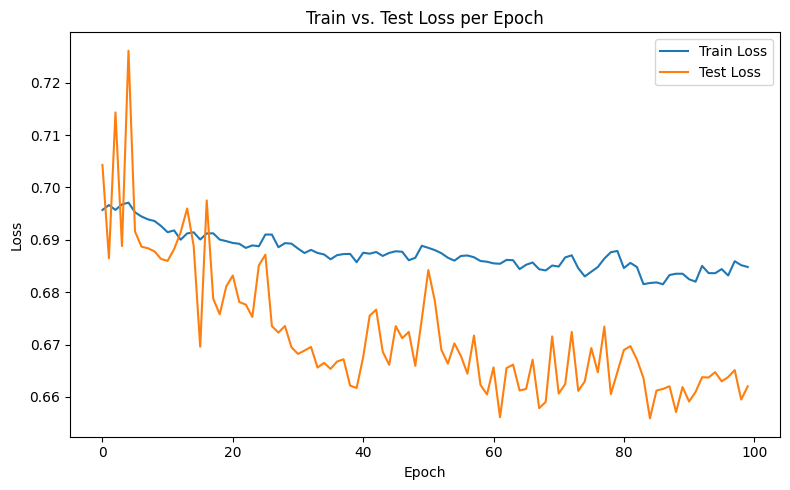

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6950
[Epoch 10/100]  Train Loss: 0.6923
[Epoch 15/100]  Train Loss: 0.6911
[Epoch 20/100]  Train Loss: 0.6896
[Epoch 25/100]  Train Loss: 0.6883
[Epoch 30/100]  Train Loss: 0.6887
[Epoch 35/100]  Train Loss: 0.6870
[Epoch 40/100]  Train Loss: 0.6890
[Epoch 45/100]  Train Loss: 0.6879
[Epoch 50/100]  Train Loss: 0.6844
[Epoch 55/100]  Train Loss: 0.6861
[Epoch 60/100]  Train Loss: 0.6851
[Epoch 65/100]  Train Loss: 0.6842
[Epoch 70/100]  Train Loss: 0.6823
[Epoch 75/100]  Train Loss: 0.6841
[Epoch 80/100]  Train Loss: 0.6821
[Epoch 85/100]  Train Loss: 0.6845
[Epoch 90/100]  Train Loss: 0.6832
[Epoch 95/100]  Train Loss: 0.6819
[Epoch 100/100]  Train Loss: 0.6835
Accuracy on Nonzero Predictions: 0.5933


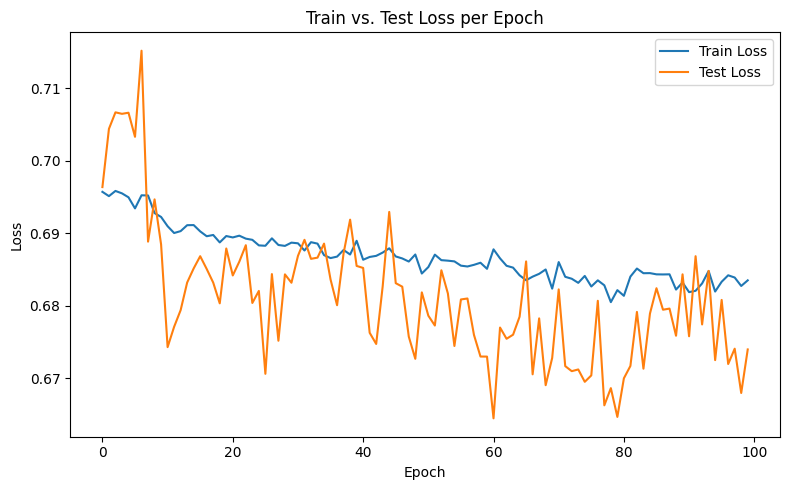

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6926
[Epoch 10/100]  Train Loss: 0.6907
[Epoch 15/100]  Train Loss: 0.6905
[Epoch 20/100]  Train Loss: 0.6873
[Epoch 25/100]  Train Loss: 0.6898
[Epoch 30/100]  Train Loss: 0.6886
[Epoch 35/100]  Train Loss: 0.6859
[Epoch 40/100]  Train Loss: 0.6855
[Epoch 45/100]  Train Loss: 0.6865
[Epoch 50/100]  Train Loss: 0.6859
[Epoch 55/100]  Train Loss: 0.6843
[Epoch 60/100]  Train Loss: 0.6840
[Epoch 65/100]  Train Loss: 0.6821
[Epoch 70/100]  Train Loss: 0.6797
[Epoch 75/100]  Train Loss: 0.6849
[Epoch 80/100]  Train Loss: 0.6784
[Epoch 85/100]  Train Loss: 0.6796
[Epoch 90/100]  Train Loss: 0.6760
[Epoch 95/100]  Train Loss: 0.6788
[Epoch 100/100]  Train Loss: 0.6799
Accuracy on Nonzero Predictions: 0.4700


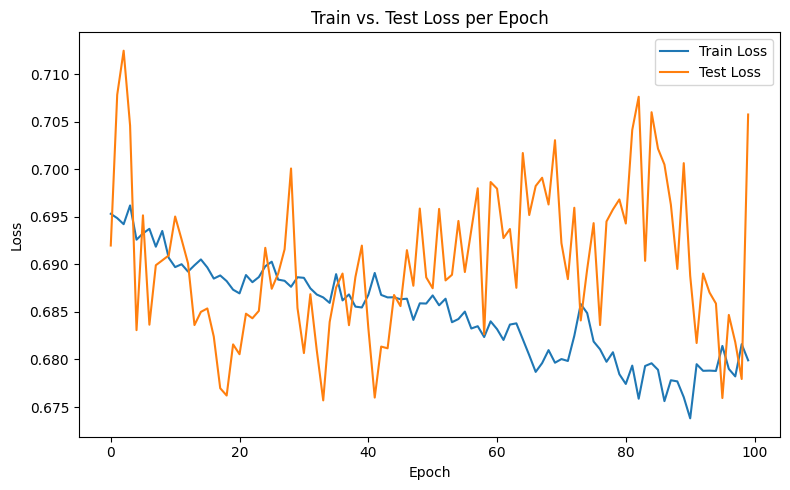

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6956
[Epoch 10/100]  Train Loss: 0.6929
[Epoch 15/100]  Train Loss: 0.6907
[Epoch 20/100]  Train Loss: 0.6914
[Epoch 25/100]  Train Loss: 0.6914
[Epoch 30/100]  Train Loss: 0.6886
[Epoch 35/100]  Train Loss: 0.6887
[Epoch 40/100]  Train Loss: 0.6887
[Epoch 45/100]  Train Loss: 0.6894
[Epoch 50/100]  Train Loss: 0.6901
[Epoch 55/100]  Train Loss: 0.6894
[Epoch 60/100]  Train Loss: 0.6873
[Epoch 65/100]  Train Loss: 0.6873
[Epoch 70/100]  Train Loss: 0.6868
[Epoch 75/100]  Train Loss: 0.6874
[Epoch 80/100]  Train Loss: 0.6858
[Epoch 85/100]  Train Loss: 0.6883
[Epoch 90/100]  Train Loss: 0.6857
[Epoch 95/100]  Train Loss: 0.6849
[Epoch 100/100]  Train Loss: 0.6859
Accuracy on Nonzero Predictions: 0.6033


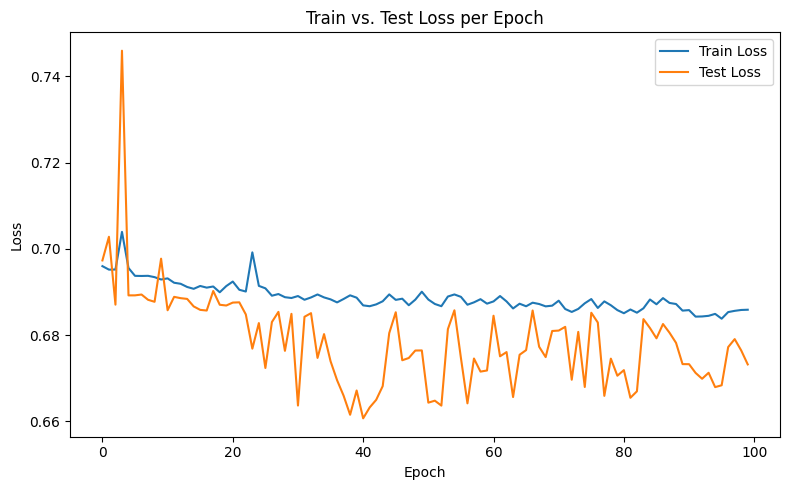

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7003
[Epoch 10/100]  Train Loss: 0.6919
[Epoch 15/100]  Train Loss: 0.6910
[Epoch 20/100]  Train Loss: 0.6889
[Epoch 25/100]  Train Loss: 0.6890
[Epoch 30/100]  Train Loss: 0.6891
[Epoch 35/100]  Train Loss: 0.6889
[Epoch 40/100]  Train Loss: 0.6897
[Epoch 45/100]  Train Loss: 0.6895
[Epoch 50/100]  Train Loss: 0.6880
[Epoch 55/100]  Train Loss: 0.6878
[Epoch 60/100]  Train Loss: 0.6868
[Epoch 65/100]  Train Loss: 0.6875
[Epoch 70/100]  Train Loss: 0.6856
[Epoch 75/100]  Train Loss: 0.6849
[Epoch 80/100]  Train Loss: 0.6858
[Epoch 85/100]  Train Loss: 0.6838
[Epoch 90/100]  Train Loss: 0.6850
[Epoch 95/100]  Train Loss: 0.6819
[Epoch 100/100]  Train Loss: 0.6808
Accuracy on Nonzero Predictions: 0.6067


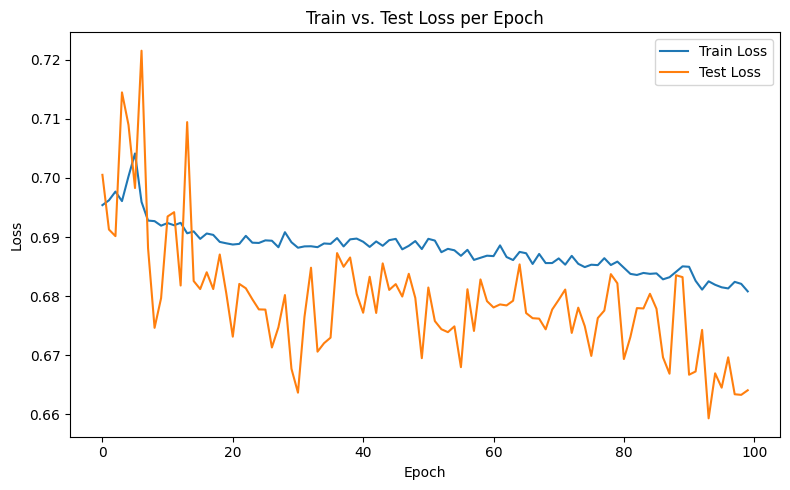

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6949
[Epoch 10/100]  Train Loss: 0.6906
[Epoch 15/100]  Train Loss: 0.6900
[Epoch 20/100]  Train Loss: 0.6869
[Epoch 25/100]  Train Loss: 0.6874
[Epoch 30/100]  Train Loss: 0.6861
[Epoch 35/100]  Train Loss: 0.6874
[Epoch 40/100]  Train Loss: 0.6851
[Epoch 45/100]  Train Loss: 0.6854
[Epoch 50/100]  Train Loss: 0.6854
[Epoch 55/100]  Train Loss: 0.6832
[Epoch 60/100]  Train Loss: 0.6885
[Epoch 65/100]  Train Loss: 0.6886
[Epoch 70/100]  Train Loss: 0.6851
[Epoch 75/100]  Train Loss: 0.6816
[Epoch 80/100]  Train Loss: 0.6837
[Epoch 85/100]  Train Loss: 0.6863
[Epoch 90/100]  Train Loss: 0.6834
[Epoch 95/100]  Train Loss: 0.6856
[Epoch 100/100]  Train Loss: 0.6856
Accuracy on Nonzero Predictions: 0.5933


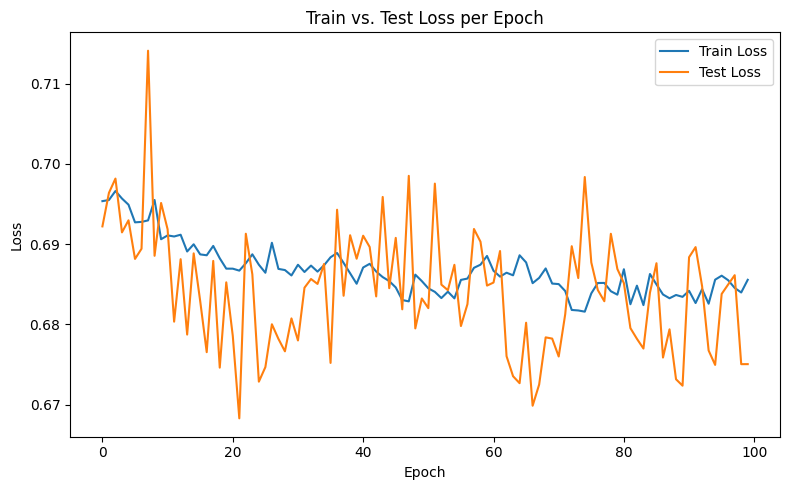

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7005
[Epoch 10/100]  Train Loss: 0.6939
[Epoch 15/100]  Train Loss: 0.6936
[Epoch 20/100]  Train Loss: 0.6924
[Epoch 25/100]  Train Loss: 0.6916
[Epoch 30/100]  Train Loss: 0.6899
[Epoch 35/100]  Train Loss: 0.6884
[Epoch 40/100]  Train Loss: 0.6886
[Epoch 45/100]  Train Loss: 0.6877
[Epoch 50/100]  Train Loss: 0.6877
[Epoch 55/100]  Train Loss: 0.6863
[Epoch 60/100]  Train Loss: 0.6879
[Epoch 65/100]  Train Loss: 0.6892
[Epoch 70/100]  Train Loss: 0.6875
[Epoch 75/100]  Train Loss: 0.6866
[Epoch 80/100]  Train Loss: 0.6894
[Epoch 85/100]  Train Loss: 0.6892
[Epoch 90/100]  Train Loss: 0.6896
[Epoch 95/100]  Train Loss: 0.6874
[Epoch 100/100]  Train Loss: 0.6870
Accuracy on Nonzero Predictions: 0.5900


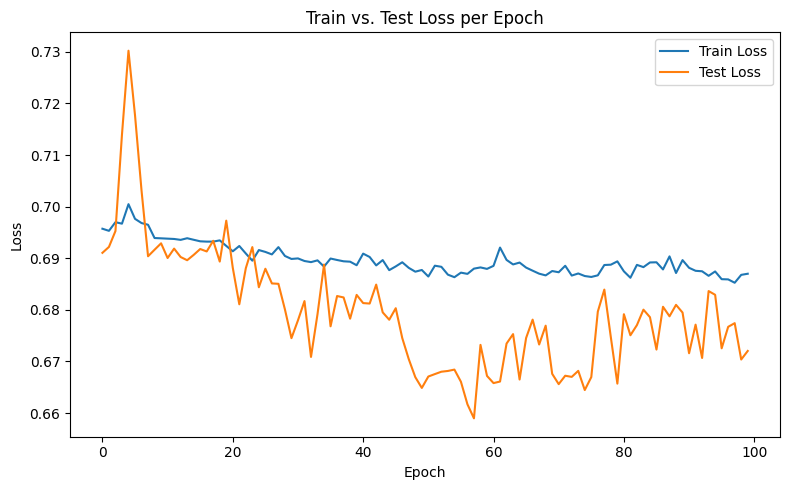

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6962
[Epoch 10/100]  Train Loss: 0.6947
[Epoch 15/100]  Train Loss: 0.6892
[Epoch 20/100]  Train Loss: 0.6914
[Epoch 25/100]  Train Loss: 0.6912
[Epoch 30/100]  Train Loss: 0.6882
[Epoch 35/100]  Train Loss: 0.6892
[Epoch 40/100]  Train Loss: 0.6866
[Epoch 45/100]  Train Loss: 0.6852
[Epoch 50/100]  Train Loss: 0.6856
[Epoch 55/100]  Train Loss: 0.6844
[Epoch 60/100]  Train Loss: 0.6871
[Epoch 65/100]  Train Loss: 0.6890
[Epoch 70/100]  Train Loss: 0.6872
[Epoch 75/100]  Train Loss: 0.6860
[Epoch 80/100]  Train Loss: 0.6854
[Epoch 85/100]  Train Loss: 0.6838
[Epoch 90/100]  Train Loss: 0.6842
[Epoch 95/100]  Train Loss: 0.6861
[Epoch 100/100]  Train Loss: 0.6832
Accuracy on Nonzero Predictions: 0.5867


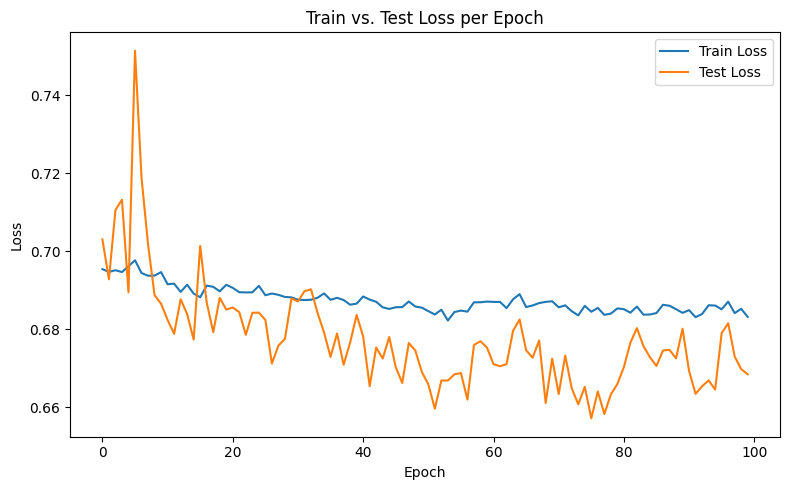

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6962
[Epoch 10/100]  Train Loss: 0.6970
[Epoch 15/100]  Train Loss: 0.6963
[Epoch 20/100]  Train Loss: 0.6955
[Epoch 25/100]  Train Loss: 0.6954
[Epoch 30/100]  Train Loss: 0.6947
[Epoch 35/100]  Train Loss: 0.6924
[Epoch 40/100]  Train Loss: 0.6921
[Epoch 45/100]  Train Loss: 0.6932
[Epoch 50/100]  Train Loss: 0.6919
[Epoch 55/100]  Train Loss: 0.6916
[Epoch 60/100]  Train Loss: 0.6911
[Epoch 65/100]  Train Loss: 0.6893
[Epoch 70/100]  Train Loss: 0.6897
[Epoch 75/100]  Train Loss: 0.6877
[Epoch 80/100]  Train Loss: 0.6881
[Epoch 85/100]  Train Loss: 0.6881
[Epoch 90/100]  Train Loss: 0.6864
[Epoch 95/100]  Train Loss: 0.6860
[Epoch 100/100]  Train Loss: 0.6853
Accuracy on Nonzero Predictions: 0.6067


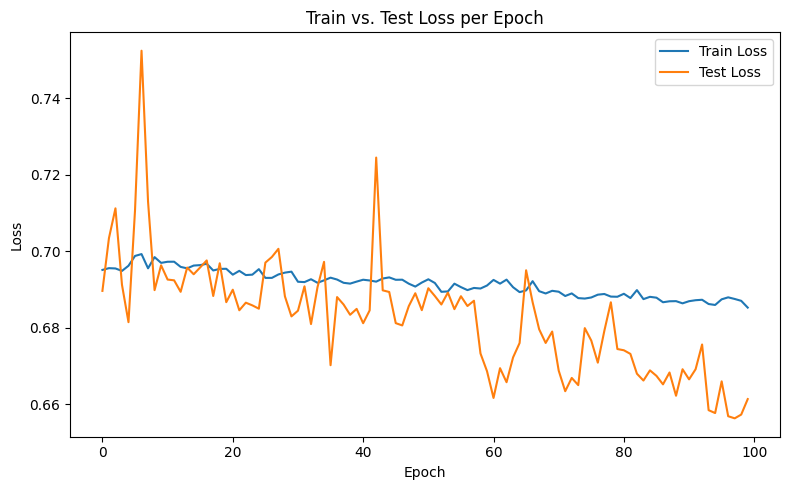

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7023
[Epoch 10/100]  Train Loss: 0.6990
[Epoch 15/100]  Train Loss: 0.6958
[Epoch 20/100]  Train Loss: 0.6918
[Epoch 25/100]  Train Loss: 0.6914
[Epoch 30/100]  Train Loss: 0.6968
[Epoch 35/100]  Train Loss: 0.6900
[Epoch 40/100]  Train Loss: 0.6902
[Epoch 45/100]  Train Loss: 0.6891
[Epoch 50/100]  Train Loss: 0.6910
[Epoch 55/100]  Train Loss: 0.6952
[Epoch 60/100]  Train Loss: 0.6903
[Epoch 65/100]  Train Loss: 0.6914
[Epoch 70/100]  Train Loss: 0.6890
[Epoch 75/100]  Train Loss: 0.6921
[Epoch 80/100]  Train Loss: 0.6899
[Epoch 85/100]  Train Loss: 0.6901
[Epoch 90/100]  Train Loss: 0.6895
[Epoch 95/100]  Train Loss: 0.6893
[Epoch 100/100]  Train Loss: 0.6902
Accuracy on Nonzero Predictions: 0.6033


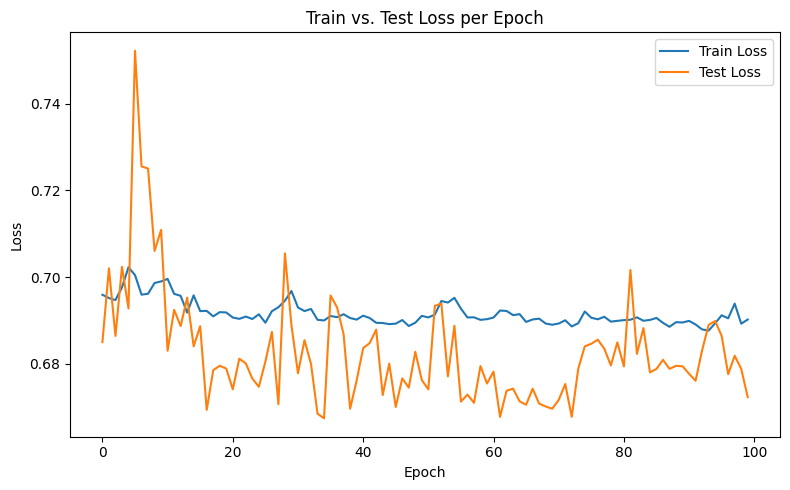

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6997
[Epoch 10/100]  Train Loss: 0.6907
[Epoch 15/100]  Train Loss: 0.6896
[Epoch 20/100]  Train Loss: 0.6900
[Epoch 25/100]  Train Loss: 0.6872
[Epoch 30/100]  Train Loss: 0.6874
[Epoch 35/100]  Train Loss: 0.6881
[Epoch 40/100]  Train Loss: 0.6875
[Epoch 45/100]  Train Loss: 0.6888
[Epoch 50/100]  Train Loss: 0.6877
[Epoch 55/100]  Train Loss: 0.6896
[Epoch 60/100]  Train Loss: 0.6871
[Epoch 65/100]  Train Loss: 0.6860
[Epoch 70/100]  Train Loss: 0.6858
[Epoch 75/100]  Train Loss: 0.6851
[Epoch 80/100]  Train Loss: 0.6861
[Epoch 85/100]  Train Loss: 0.6830
[Epoch 90/100]  Train Loss: 0.6820
[Epoch 95/100]  Train Loss: 0.6840
[Epoch 100/100]  Train Loss: 0.6826
Accuracy on Nonzero Predictions: 0.5767


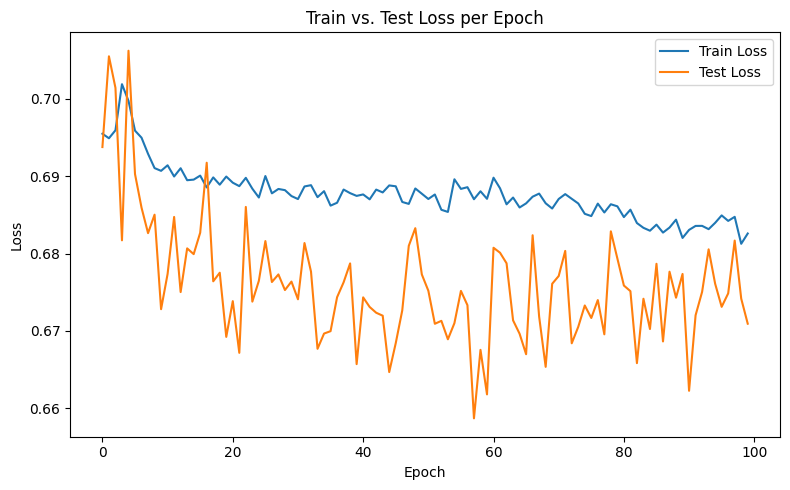

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7054
[Epoch 10/100]  Train Loss: 0.6963
[Epoch 15/100]  Train Loss: 0.6944
[Epoch 20/100]  Train Loss: 0.6901
[Epoch 25/100]  Train Loss: 0.6901
[Epoch 30/100]  Train Loss: 0.6929
[Epoch 35/100]  Train Loss: 0.6879
[Epoch 40/100]  Train Loss: 0.6890
[Epoch 45/100]  Train Loss: 0.6851
[Epoch 50/100]  Train Loss: 0.6868
[Epoch 55/100]  Train Loss: 0.6844
[Epoch 60/100]  Train Loss: 0.6817
[Epoch 65/100]  Train Loss: 0.6831
[Epoch 70/100]  Train Loss: 0.6828
[Epoch 75/100]  Train Loss: 0.6825
[Epoch 80/100]  Train Loss: 0.6807
[Epoch 85/100]  Train Loss: 0.6808
[Epoch 90/100]  Train Loss: 0.6832
[Epoch 95/100]  Train Loss: 0.6802
[Epoch 100/100]  Train Loss: 0.6783
Accuracy on Nonzero Predictions: 0.6033


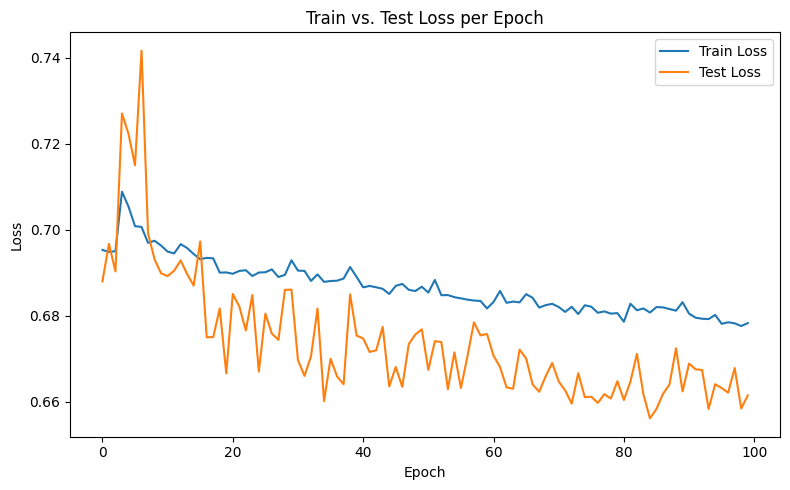

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6945
[Epoch 10/100]  Train Loss: 0.6904
[Epoch 15/100]  Train Loss: 0.6887
[Epoch 20/100]  Train Loss: 0.6895
[Epoch 25/100]  Train Loss: 0.6882
[Epoch 30/100]  Train Loss: 0.6873
[Epoch 35/100]  Train Loss: 0.6852
[Epoch 40/100]  Train Loss: 0.6871
[Epoch 45/100]  Train Loss: 0.6872
[Epoch 50/100]  Train Loss: 0.6849
[Epoch 55/100]  Train Loss: 0.6859
[Epoch 60/100]  Train Loss: 0.6848
[Epoch 65/100]  Train Loss: 0.6856
[Epoch 70/100]  Train Loss: 0.6864
[Epoch 75/100]  Train Loss: 0.6861
[Epoch 80/100]  Train Loss: 0.6823
[Epoch 85/100]  Train Loss: 0.6856
[Epoch 90/100]  Train Loss: 0.6840
[Epoch 95/100]  Train Loss: 0.6809
[Epoch 100/100]  Train Loss: 0.6818
Accuracy on Nonzero Predictions: 0.5533


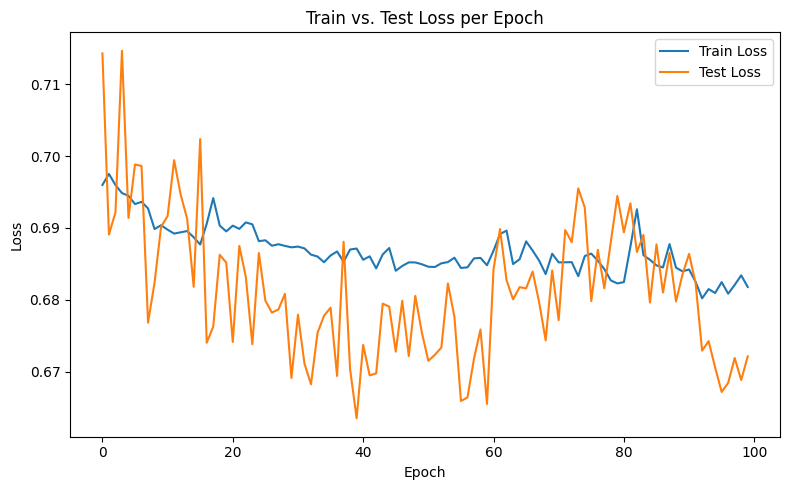

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6964
[Epoch 10/100]  Train Loss: 0.6908
[Epoch 15/100]  Train Loss: 0.6895
[Epoch 20/100]  Train Loss: 0.6897
[Epoch 25/100]  Train Loss: 0.6877
[Epoch 30/100]  Train Loss: 0.6891
[Epoch 35/100]  Train Loss: 0.6876
[Epoch 40/100]  Train Loss: 0.6875
[Epoch 45/100]  Train Loss: 0.6881
[Epoch 50/100]  Train Loss: 0.6864
[Epoch 55/100]  Train Loss: 0.6876
[Epoch 60/100]  Train Loss: 0.6863
[Epoch 65/100]  Train Loss: 0.6876
[Epoch 70/100]  Train Loss: 0.6889
[Epoch 75/100]  Train Loss: 0.6896
[Epoch 80/100]  Train Loss: 0.6863
[Epoch 85/100]  Train Loss: 0.6867
[Epoch 90/100]  Train Loss: 0.6846
[Epoch 95/100]  Train Loss: 0.6854
[Epoch 100/100]  Train Loss: 0.6842
Accuracy on Nonzero Predictions: 0.6100


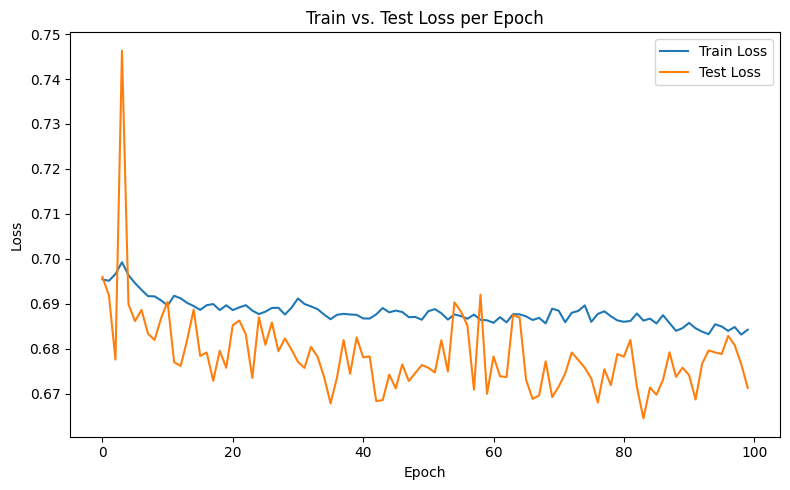

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6957
[Epoch 10/100]  Train Loss: 0.6964
[Epoch 15/100]  Train Loss: 0.6942
[Epoch 20/100]  Train Loss: 0.6958
[Epoch 25/100]  Train Loss: 0.6932
[Epoch 30/100]  Train Loss: 0.6902
[Epoch 35/100]  Train Loss: 0.6933
[Epoch 40/100]  Train Loss: 0.6925
[Epoch 45/100]  Train Loss: 0.6915
[Epoch 50/100]  Train Loss: 0.6891
[Epoch 55/100]  Train Loss: 0.6907
[Epoch 60/100]  Train Loss: 0.6892
[Epoch 65/100]  Train Loss: 0.6884
[Epoch 70/100]  Train Loss: 0.6884
[Epoch 75/100]  Train Loss: 0.6890
[Epoch 80/100]  Train Loss: 0.6911
[Epoch 85/100]  Train Loss: 0.6893
[Epoch 90/100]  Train Loss: 0.6887
[Epoch 95/100]  Train Loss: 0.6896
[Epoch 100/100]  Train Loss: 0.6892
Accuracy on Nonzero Predictions: 0.5467


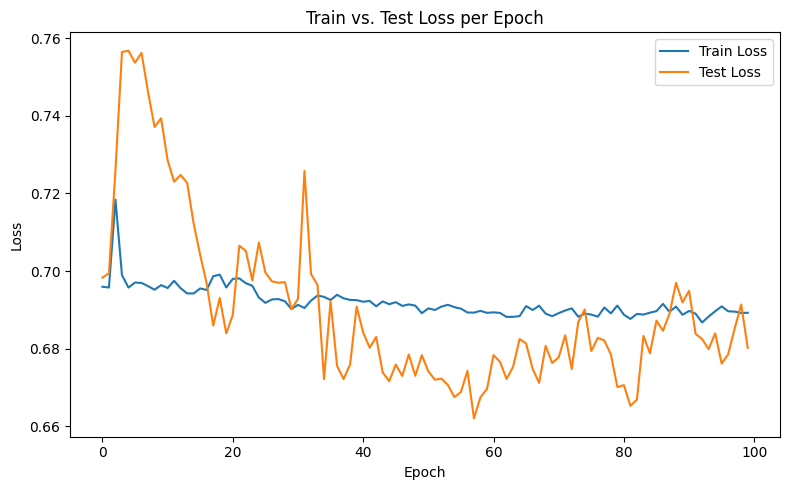

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6962
[Epoch 10/100]  Train Loss: 0.6930
[Epoch 15/100]  Train Loss: 0.6900
[Epoch 20/100]  Train Loss: 0.6883
[Epoch 25/100]  Train Loss: 0.6905
[Epoch 30/100]  Train Loss: 0.6882
[Epoch 35/100]  Train Loss: 0.6880
[Epoch 40/100]  Train Loss: 0.6882
[Epoch 45/100]  Train Loss: 0.6873
[Epoch 50/100]  Train Loss: 0.6874
[Epoch 55/100]  Train Loss: 0.6865
[Epoch 60/100]  Train Loss: 0.6871
[Epoch 65/100]  Train Loss: 0.6847
[Epoch 70/100]  Train Loss: 0.6840
[Epoch 75/100]  Train Loss: 0.6881
[Epoch 80/100]  Train Loss: 0.6861
[Epoch 85/100]  Train Loss: 0.6848
[Epoch 90/100]  Train Loss: 0.6861
[Epoch 95/100]  Train Loss: 0.6850
[Epoch 100/100]  Train Loss: 0.6842
Accuracy on Nonzero Predictions: 0.6000


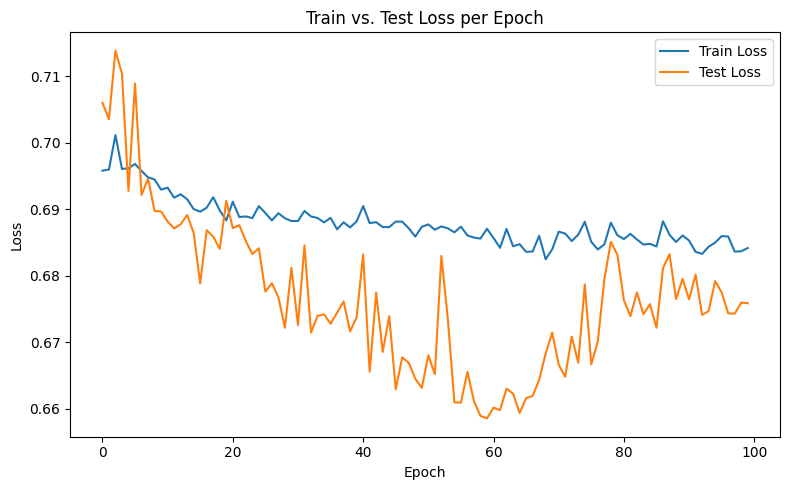

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6959
[Epoch 10/100]  Train Loss: 0.6936
[Epoch 15/100]  Train Loss: 0.6915
[Epoch 20/100]  Train Loss: 0.6914
[Epoch 25/100]  Train Loss: 0.6907
[Epoch 30/100]  Train Loss: 0.6925
[Epoch 35/100]  Train Loss: 0.6902
[Epoch 40/100]  Train Loss: 0.6884
[Epoch 45/100]  Train Loss: 0.6890
[Epoch 50/100]  Train Loss: 0.6877
[Epoch 55/100]  Train Loss: 0.6893
[Epoch 60/100]  Train Loss: 0.6891
[Epoch 65/100]  Train Loss: 0.6867
[Epoch 70/100]  Train Loss: 0.6877
[Epoch 75/100]  Train Loss: 0.6874
[Epoch 80/100]  Train Loss: 0.6891
[Epoch 85/100]  Train Loss: 0.6881
[Epoch 90/100]  Train Loss: 0.6894
[Epoch 95/100]  Train Loss: 0.6881
[Epoch 100/100]  Train Loss: 0.6885
Accuracy on Nonzero Predictions: 0.5967


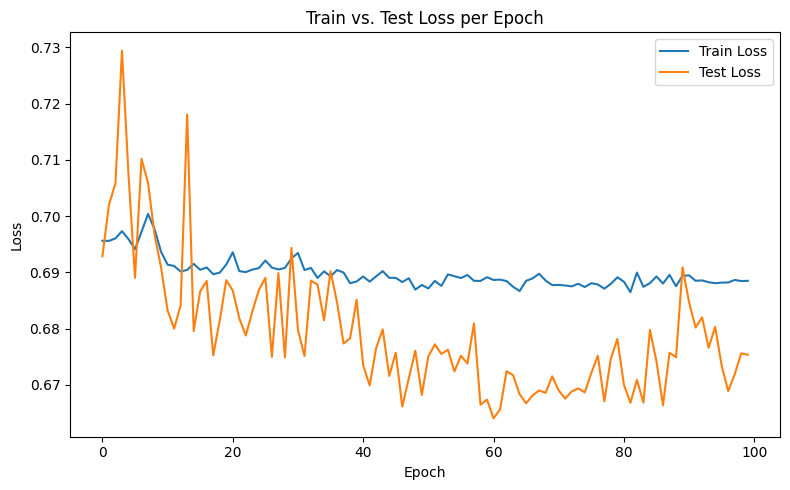

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6933
[Epoch 10/100]  Train Loss: 0.6911
[Epoch 15/100]  Train Loss: 0.6893
[Epoch 20/100]  Train Loss: 0.6903
[Epoch 25/100]  Train Loss: 0.6903
[Epoch 30/100]  Train Loss: 0.6882
[Epoch 35/100]  Train Loss: 0.6894
[Epoch 40/100]  Train Loss: 0.6884
[Epoch 45/100]  Train Loss: 0.6876
[Epoch 50/100]  Train Loss: 0.6926
[Epoch 55/100]  Train Loss: 0.6895
[Epoch 60/100]  Train Loss: 0.6890
[Epoch 65/100]  Train Loss: 0.6884
[Epoch 70/100]  Train Loss: 0.6876
[Epoch 75/100]  Train Loss: 0.6880
[Epoch 80/100]  Train Loss: 0.6879
[Epoch 85/100]  Train Loss: 0.6879
[Epoch 90/100]  Train Loss: 0.6854
[Epoch 95/100]  Train Loss: 0.6860
[Epoch 100/100]  Train Loss: 0.6861
Accuracy on Nonzero Predictions: 0.6033


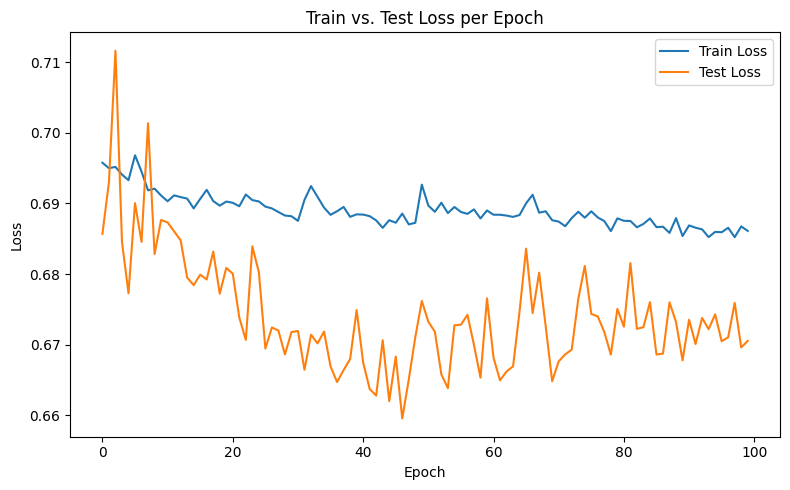

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6944
[Epoch 10/100]  Train Loss: 0.6910
[Epoch 15/100]  Train Loss: 0.6911
[Epoch 20/100]  Train Loss: 0.6916
[Epoch 25/100]  Train Loss: 0.6875
[Epoch 30/100]  Train Loss: 0.6900
[Epoch 35/100]  Train Loss: 0.6875
[Epoch 40/100]  Train Loss: 0.6882
[Epoch 45/100]  Train Loss: 0.6879
[Epoch 50/100]  Train Loss: 0.6865
[Epoch 55/100]  Train Loss: 0.6872
[Epoch 60/100]  Train Loss: 0.6864
[Epoch 65/100]  Train Loss: 0.6890
[Epoch 70/100]  Train Loss: 0.6897
[Epoch 75/100]  Train Loss: 0.6872
[Epoch 80/100]  Train Loss: 0.6860
[Epoch 85/100]  Train Loss: 0.6865
[Epoch 90/100]  Train Loss: 0.6842
[Epoch 95/100]  Train Loss: 0.6838
[Epoch 100/100]  Train Loss: 0.6849
Accuracy on Nonzero Predictions: 0.6133


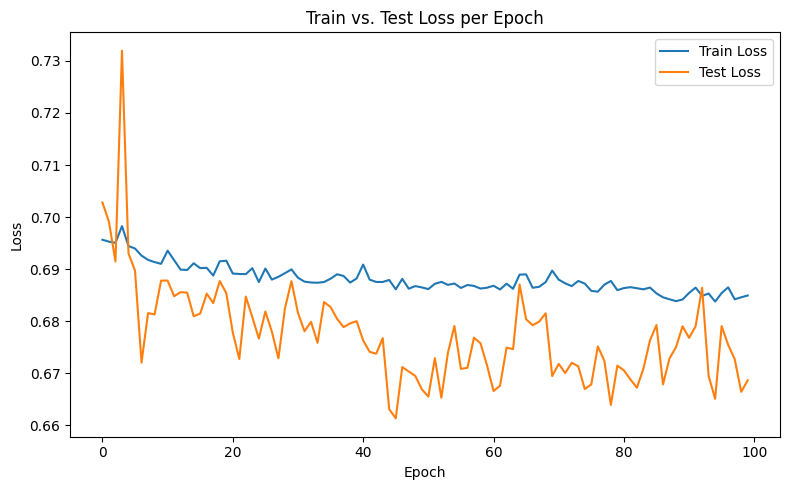

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6940
[Epoch 10/100]  Train Loss: 0.6898
[Epoch 15/100]  Train Loss: 0.6880
[Epoch 20/100]  Train Loss: 0.6867
[Epoch 25/100]  Train Loss: 0.6863
[Epoch 30/100]  Train Loss: 0.6854
[Epoch 35/100]  Train Loss: 0.6868
[Epoch 40/100]  Train Loss: 0.6850
[Epoch 45/100]  Train Loss: 0.6864
[Epoch 50/100]  Train Loss: 0.6853
[Epoch 55/100]  Train Loss: 0.6877
[Epoch 60/100]  Train Loss: 0.6836
[Epoch 65/100]  Train Loss: 0.6862
[Epoch 70/100]  Train Loss: 0.6844
[Epoch 75/100]  Train Loss: 0.6823
[Epoch 80/100]  Train Loss: 0.6873
[Epoch 85/100]  Train Loss: 0.6829
[Epoch 90/100]  Train Loss: 0.6818
[Epoch 95/100]  Train Loss: 0.6842
[Epoch 100/100]  Train Loss: 0.6820
Accuracy on Nonzero Predictions: 0.5633


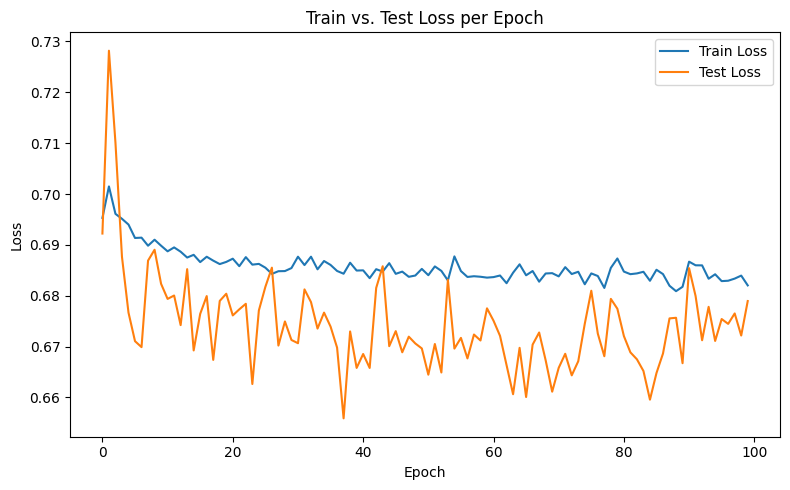

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6963
[Epoch 10/100]  Train Loss: 0.6965
[Epoch 15/100]  Train Loss: 0.6943
[Epoch 20/100]  Train Loss: 0.6921
[Epoch 25/100]  Train Loss: 0.6892
[Epoch 30/100]  Train Loss: 0.6887
[Epoch 35/100]  Train Loss: 0.6883
[Epoch 40/100]  Train Loss: 0.6882
[Epoch 45/100]  Train Loss: 0.6887
[Epoch 50/100]  Train Loss: 0.6865
[Epoch 55/100]  Train Loss: 0.6882
[Epoch 60/100]  Train Loss: 0.6881
[Epoch 65/100]  Train Loss: 0.6863
[Epoch 70/100]  Train Loss: 0.6845
[Epoch 75/100]  Train Loss: 0.6851
[Epoch 80/100]  Train Loss: 0.6838
[Epoch 85/100]  Train Loss: 0.6843
[Epoch 90/100]  Train Loss: 0.6844
[Epoch 95/100]  Train Loss: 0.6855
[Epoch 100/100]  Train Loss: 0.6829
Accuracy on Nonzero Predictions: 0.5600


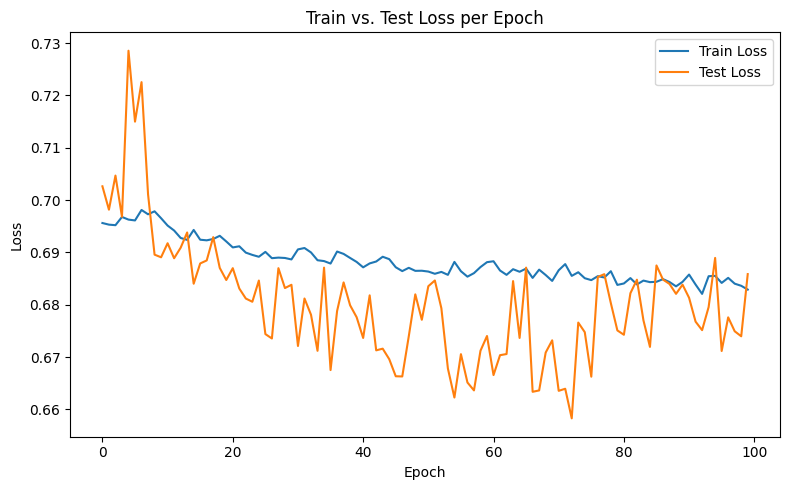

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6968
[Epoch 10/100]  Train Loss: 0.6943
[Epoch 15/100]  Train Loss: 0.6912
[Epoch 20/100]  Train Loss: 0.6891
[Epoch 25/100]  Train Loss: 0.6891
[Epoch 30/100]  Train Loss: 0.6879
[Epoch 35/100]  Train Loss: 0.6864
[Epoch 40/100]  Train Loss: 0.6874
[Epoch 45/100]  Train Loss: 0.6879
[Epoch 50/100]  Train Loss: 0.6868
[Epoch 55/100]  Train Loss: 0.6861
[Epoch 60/100]  Train Loss: 0.6865
[Epoch 65/100]  Train Loss: 0.6872
[Epoch 70/100]  Train Loss: 0.6843
[Epoch 75/100]  Train Loss: 0.6853
[Epoch 80/100]  Train Loss: 0.6871
[Epoch 85/100]  Train Loss: 0.6839
[Epoch 90/100]  Train Loss: 0.6870
[Epoch 95/100]  Train Loss: 0.6858
[Epoch 100/100]  Train Loss: 0.6853
Accuracy on Nonzero Predictions: 0.5800


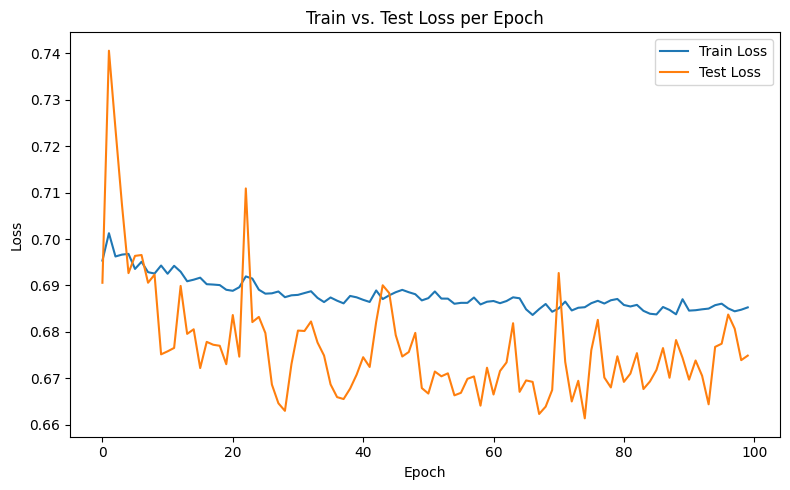

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6926
[Epoch 10/100]  Train Loss: 0.6924
[Epoch 15/100]  Train Loss: 0.6889
[Epoch 20/100]  Train Loss: 0.6862
[Epoch 25/100]  Train Loss: 0.6849
[Epoch 30/100]  Train Loss: 0.6830
[Epoch 35/100]  Train Loss: 0.6866
[Epoch 40/100]  Train Loss: 0.6839
[Epoch 45/100]  Train Loss: 0.6831
[Epoch 50/100]  Train Loss: 0.6770
[Epoch 55/100]  Train Loss: 0.6803
[Epoch 60/100]  Train Loss: 0.6778
[Epoch 65/100]  Train Loss: 0.6799
[Epoch 70/100]  Train Loss: 0.6807
[Epoch 75/100]  Train Loss: 0.6843
[Epoch 80/100]  Train Loss: 0.6775
[Epoch 85/100]  Train Loss: 0.6731
[Epoch 90/100]  Train Loss: 0.6718
[Epoch 95/100]  Train Loss: 0.6825
[Epoch 100/100]  Train Loss: 0.6754
Accuracy on Nonzero Predictions: 0.5500


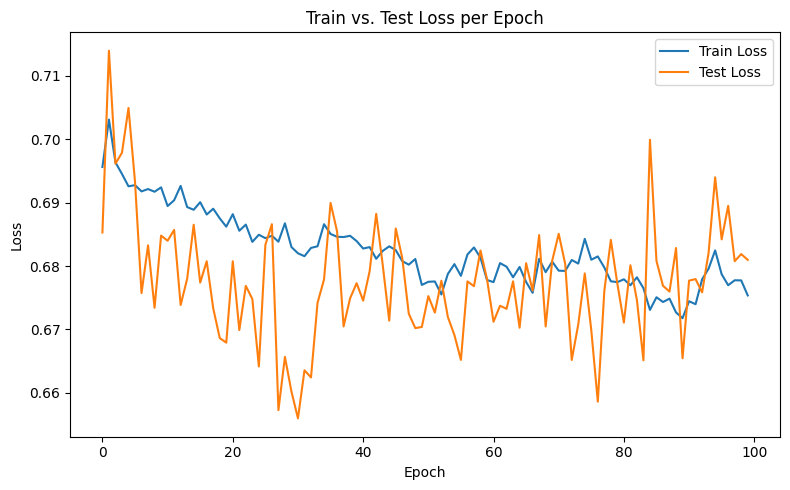

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6962
[Epoch 10/100]  Train Loss: 0.6894
[Epoch 15/100]  Train Loss: 0.6891
[Epoch 20/100]  Train Loss: 0.6868
[Epoch 25/100]  Train Loss: 0.6859
[Epoch 30/100]  Train Loss: 0.6860
[Epoch 35/100]  Train Loss: 0.6862
[Epoch 40/100]  Train Loss: 0.6836
[Epoch 45/100]  Train Loss: 0.6857
[Epoch 50/100]  Train Loss: 0.6847
[Epoch 55/100]  Train Loss: 0.6847
[Epoch 60/100]  Train Loss: 0.6832
[Epoch 65/100]  Train Loss: 0.6848
[Epoch 70/100]  Train Loss: 0.6832
[Epoch 75/100]  Train Loss: 0.6852
[Epoch 80/100]  Train Loss: 0.6834
[Epoch 85/100]  Train Loss: 0.6841
[Epoch 90/100]  Train Loss: 0.6834
[Epoch 95/100]  Train Loss: 0.6859
[Epoch 100/100]  Train Loss: 0.6828
Accuracy on Nonzero Predictions: 0.5267


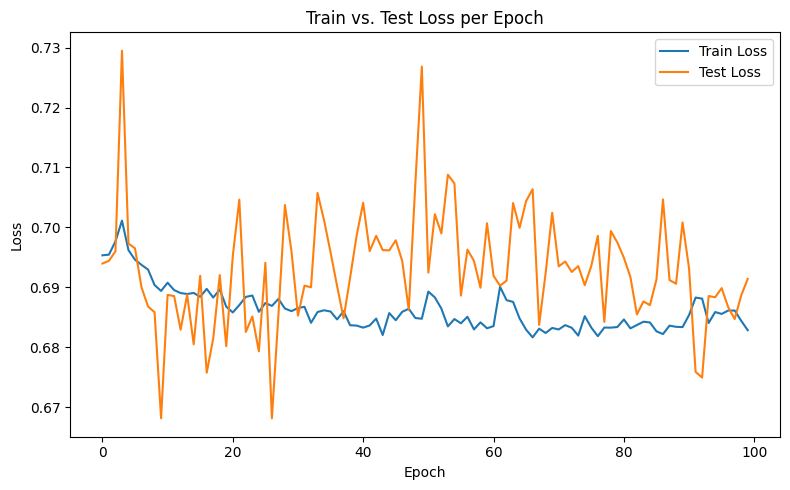

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6936
[Epoch 10/100]  Train Loss: 0.6936
[Epoch 15/100]  Train Loss: 0.6906
[Epoch 20/100]  Train Loss: 0.6894
[Epoch 25/100]  Train Loss: 0.6886
[Epoch 30/100]  Train Loss: 0.6887
[Epoch 35/100]  Train Loss: 0.6884
[Epoch 40/100]  Train Loss: 0.6872
[Epoch 45/100]  Train Loss: 0.6873
[Epoch 50/100]  Train Loss: 0.6870
[Epoch 55/100]  Train Loss: 0.6902
[Epoch 60/100]  Train Loss: 0.6879
[Epoch 65/100]  Train Loss: 0.6876
[Epoch 70/100]  Train Loss: 0.6853
[Epoch 75/100]  Train Loss: 0.6850
[Epoch 80/100]  Train Loss: 0.6861
[Epoch 85/100]  Train Loss: 0.6857
[Epoch 90/100]  Train Loss: 0.6837
[Epoch 95/100]  Train Loss: 0.6852
[Epoch 100/100]  Train Loss: 0.6841
Accuracy on Nonzero Predictions: 0.5500


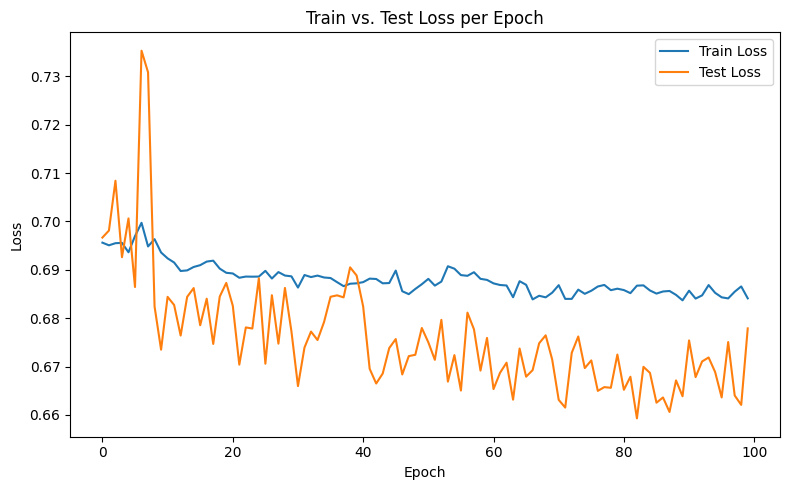

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6939
[Epoch 10/100]  Train Loss: 0.6920
[Epoch 15/100]  Train Loss: 0.6903
[Epoch 20/100]  Train Loss: 0.6929
[Epoch 25/100]  Train Loss: 0.6923
[Epoch 30/100]  Train Loss: 0.6891
[Epoch 35/100]  Train Loss: 0.6917
[Epoch 40/100]  Train Loss: 0.6881
[Epoch 45/100]  Train Loss: 0.6863
[Epoch 50/100]  Train Loss: 0.6859
[Epoch 55/100]  Train Loss: 0.6858
[Epoch 60/100]  Train Loss: 0.6841
[Epoch 65/100]  Train Loss: 0.6856
[Epoch 70/100]  Train Loss: 0.6857
[Epoch 75/100]  Train Loss: 0.6835
[Epoch 80/100]  Train Loss: 0.6827
[Epoch 85/100]  Train Loss: 0.6799
[Epoch 90/100]  Train Loss: 0.6813
[Epoch 95/100]  Train Loss: 0.6807
[Epoch 100/100]  Train Loss: 0.6810
Accuracy on Nonzero Predictions: 0.5533


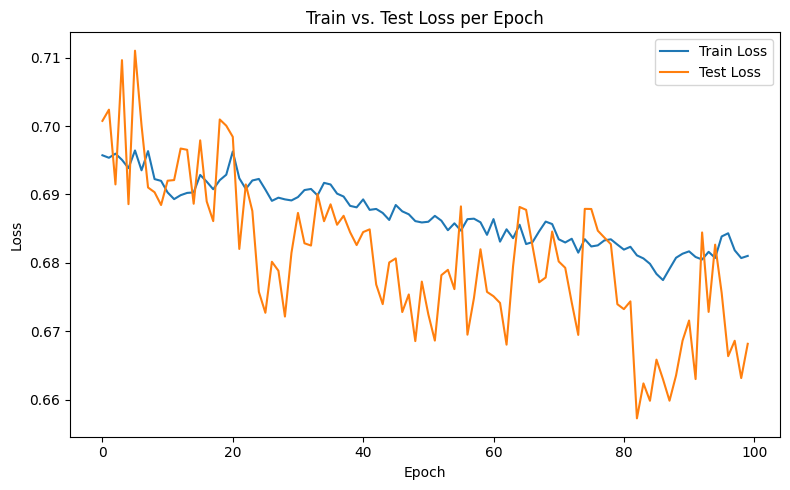

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6943
[Epoch 10/100]  Train Loss: 0.6939
[Epoch 15/100]  Train Loss: 0.6912
[Epoch 20/100]  Train Loss: 0.6908
[Epoch 25/100]  Train Loss: 0.6888
[Epoch 30/100]  Train Loss: 0.6890
[Epoch 35/100]  Train Loss: 0.6889
[Epoch 40/100]  Train Loss: 0.6889
[Epoch 45/100]  Train Loss: 0.6887
[Epoch 50/100]  Train Loss: 0.6889
[Epoch 55/100]  Train Loss: 0.6875
[Epoch 60/100]  Train Loss: 0.6880
[Epoch 65/100]  Train Loss: 0.6871
[Epoch 70/100]  Train Loss: 0.6923
[Epoch 75/100]  Train Loss: 0.6869
[Epoch 80/100]  Train Loss: 0.6893
[Epoch 85/100]  Train Loss: 0.6859
[Epoch 90/100]  Train Loss: 0.6879
[Epoch 95/100]  Train Loss: 0.6889
[Epoch 100/100]  Train Loss: 0.6880
Accuracy on Nonzero Predictions: 0.4933


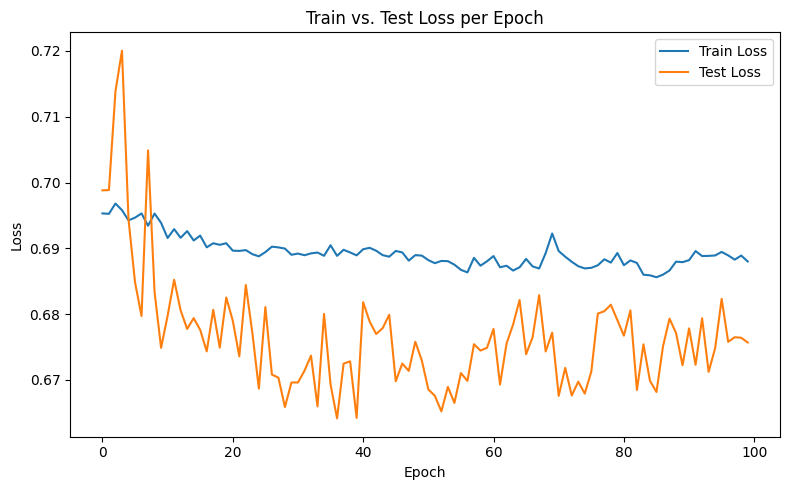

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6941
[Epoch 10/100]  Train Loss: 0.6915
[Epoch 15/100]  Train Loss: 0.6903
[Epoch 20/100]  Train Loss: 0.6899
[Epoch 25/100]  Train Loss: 0.6892
[Epoch 30/100]  Train Loss: 0.6873
[Epoch 35/100]  Train Loss: 0.6897
[Epoch 40/100]  Train Loss: 0.6902
[Epoch 45/100]  Train Loss: 0.6908
[Epoch 50/100]  Train Loss: 0.6881
[Epoch 55/100]  Train Loss: 0.6866
[Epoch 60/100]  Train Loss: 0.6880
[Epoch 65/100]  Train Loss: 0.6882
[Epoch 70/100]  Train Loss: 0.6877
[Epoch 75/100]  Train Loss: 0.6882
[Epoch 80/100]  Train Loss: 0.6886
[Epoch 85/100]  Train Loss: 0.6870
[Epoch 90/100]  Train Loss: 0.6863
[Epoch 95/100]  Train Loss: 0.6878
[Epoch 100/100]  Train Loss: 0.6863
Accuracy on Nonzero Predictions: 0.5933


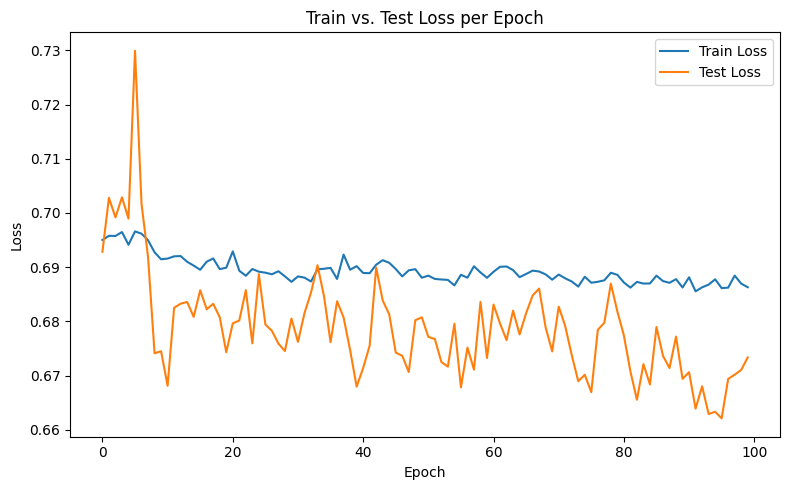

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6952
[Epoch 10/100]  Train Loss: 0.6918
[Epoch 15/100]  Train Loss: 0.6890
[Epoch 20/100]  Train Loss: 0.6887
[Epoch 25/100]  Train Loss: 0.6873
[Epoch 30/100]  Train Loss: 0.6862
[Epoch 35/100]  Train Loss: 0.6845
[Epoch 40/100]  Train Loss: 0.6829
[Epoch 45/100]  Train Loss: 0.6815
[Epoch 50/100]  Train Loss: 0.6804
[Epoch 55/100]  Train Loss: 0.6796
[Epoch 60/100]  Train Loss: 0.6823
[Epoch 65/100]  Train Loss: 0.6793
[Epoch 70/100]  Train Loss: 0.6766
[Epoch 75/100]  Train Loss: 0.6818
[Epoch 80/100]  Train Loss: 0.6770
[Epoch 85/100]  Train Loss: 0.6720
[Epoch 90/100]  Train Loss: 0.6730
[Epoch 95/100]  Train Loss: 0.6713
[Epoch 100/100]  Train Loss: 0.6703
Accuracy on Nonzero Predictions: 0.5633


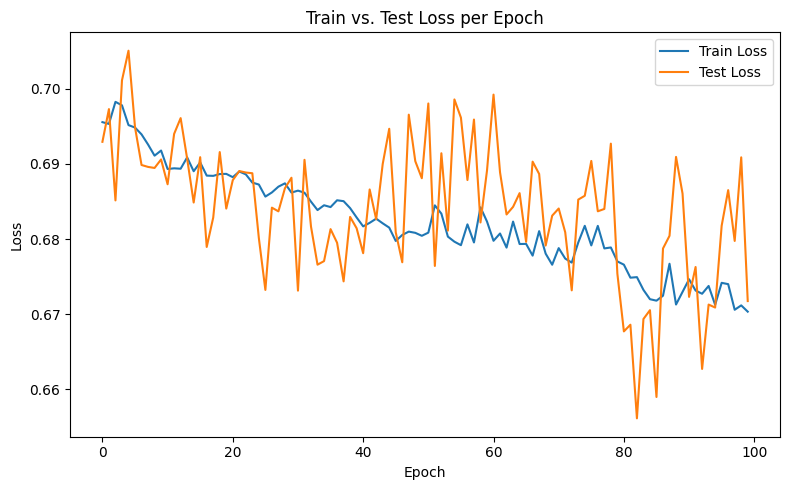

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6953
[Epoch 10/100]  Train Loss: 0.6913
[Epoch 15/100]  Train Loss: 0.6883
[Epoch 20/100]  Train Loss: 0.6889
[Epoch 25/100]  Train Loss: 0.6870
[Epoch 30/100]  Train Loss: 0.6912
[Epoch 35/100]  Train Loss: 0.6877
[Epoch 40/100]  Train Loss: 0.6870
[Epoch 45/100]  Train Loss: 0.6881
[Epoch 50/100]  Train Loss: 0.6889
[Epoch 55/100]  Train Loss: 0.6868
[Epoch 60/100]  Train Loss: 0.6879
[Epoch 65/100]  Train Loss: 0.6879
[Epoch 70/100]  Train Loss: 0.6855
[Epoch 75/100]  Train Loss: 0.6884
[Epoch 80/100]  Train Loss: 0.6869
[Epoch 85/100]  Train Loss: 0.6884
[Epoch 90/100]  Train Loss: 0.6871
[Epoch 95/100]  Train Loss: 0.6859
[Epoch 100/100]  Train Loss: 0.6871
Accuracy on Nonzero Predictions: 0.6000


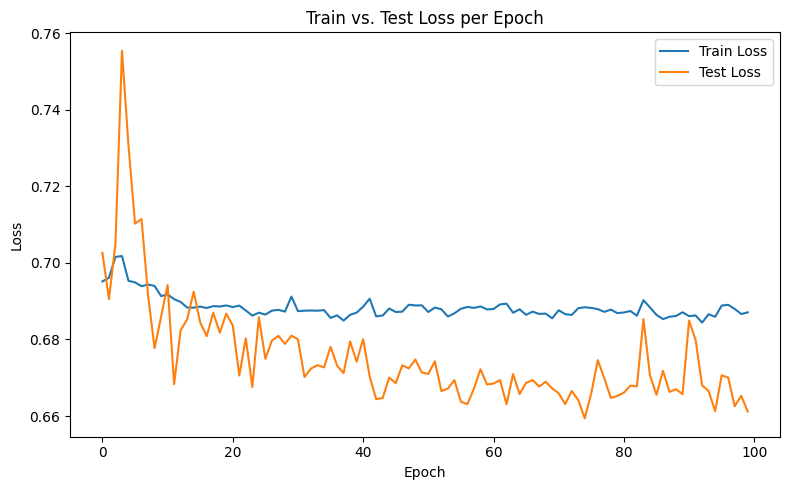

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6953
[Epoch 10/100]  Train Loss: 0.6965
[Epoch 15/100]  Train Loss: 0.6994
[Epoch 20/100]  Train Loss: 0.6937
[Epoch 25/100]  Train Loss: 0.7014
[Epoch 30/100]  Train Loss: 0.6922
[Epoch 35/100]  Train Loss: 0.6918
[Epoch 40/100]  Train Loss: 0.6914
[Epoch 45/100]  Train Loss: 0.6891
[Epoch 50/100]  Train Loss: 0.6920
[Epoch 55/100]  Train Loss: 0.6900
[Epoch 60/100]  Train Loss: 0.6909
[Epoch 65/100]  Train Loss: 0.6906
[Epoch 70/100]  Train Loss: 0.6924
[Epoch 75/100]  Train Loss: 0.6915
[Epoch 80/100]  Train Loss: 0.6904
[Epoch 85/100]  Train Loss: 0.6923
[Epoch 90/100]  Train Loss: 0.6908
[Epoch 95/100]  Train Loss: 0.6895
[Epoch 100/100]  Train Loss: 0.6909
Accuracy on Nonzero Predictions: 0.5800


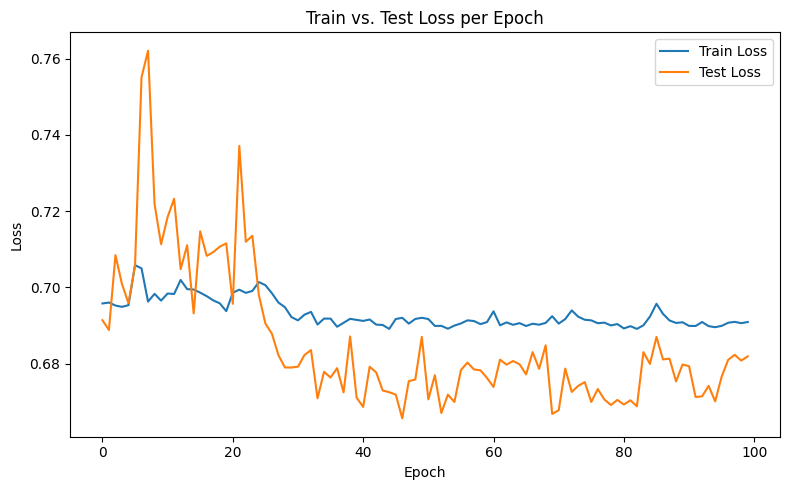

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6983
[Epoch 10/100]  Train Loss: 0.6917
[Epoch 15/100]  Train Loss: 0.6896
[Epoch 20/100]  Train Loss: 0.6902
[Epoch 25/100]  Train Loss: 0.6884
[Epoch 30/100]  Train Loss: 0.6871
[Epoch 35/100]  Train Loss: 0.6867
[Epoch 40/100]  Train Loss: 0.6916
[Epoch 45/100]  Train Loss: 0.6905
[Epoch 50/100]  Train Loss: 0.6885
[Epoch 55/100]  Train Loss: 0.6899
[Epoch 60/100]  Train Loss: 0.6878
[Epoch 65/100]  Train Loss: 0.6865
[Epoch 70/100]  Train Loss: 0.6891
[Epoch 75/100]  Train Loss: 0.6871
[Epoch 80/100]  Train Loss: 0.6863
[Epoch 85/100]  Train Loss: 0.6846
[Epoch 90/100]  Train Loss: 0.6855
[Epoch 95/100]  Train Loss: 0.6858
[Epoch 100/100]  Train Loss: 0.6841
Accuracy on Nonzero Predictions: 0.6000


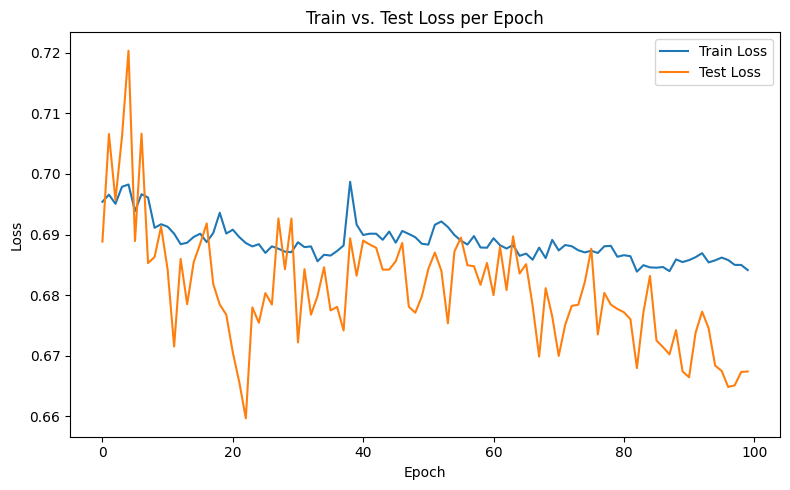

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7029
[Epoch 10/100]  Train Loss: 0.6962
[Epoch 15/100]  Train Loss: 0.6964
[Epoch 20/100]  Train Loss: 0.6941
[Epoch 25/100]  Train Loss: 0.6936
[Epoch 30/100]  Train Loss: 0.6900
[Epoch 35/100]  Train Loss: 0.6904
[Epoch 40/100]  Train Loss: 0.6913
[Epoch 45/100]  Train Loss: 0.6933
[Epoch 50/100]  Train Loss: 0.6955
[Epoch 55/100]  Train Loss: 0.6904
[Epoch 60/100]  Train Loss: 0.6895
[Epoch 65/100]  Train Loss: 0.6902
[Epoch 70/100]  Train Loss: 0.6912
[Epoch 75/100]  Train Loss: 0.6894
[Epoch 80/100]  Train Loss: 0.6906
[Epoch 85/100]  Train Loss: 0.6881
[Epoch 90/100]  Train Loss: 0.6909
[Epoch 95/100]  Train Loss: 0.6875
[Epoch 100/100]  Train Loss: 0.6872
Accuracy on Nonzero Predictions: 0.5633


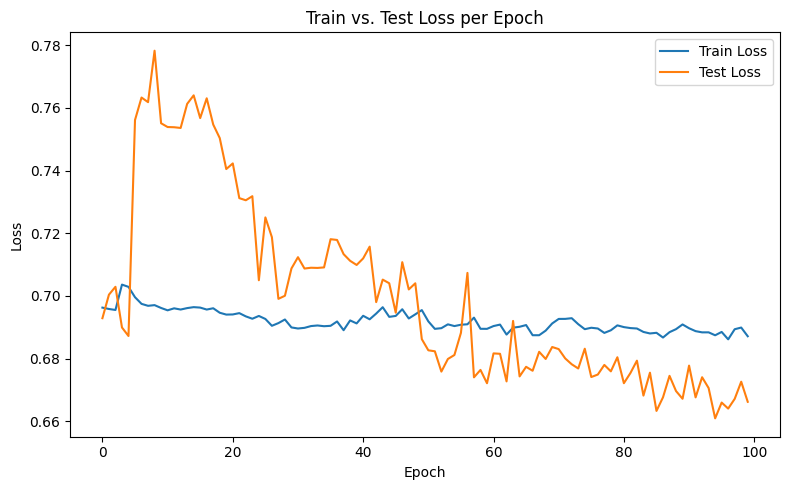

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6961
[Epoch 10/100]  Train Loss: 0.6924
[Epoch 15/100]  Train Loss: 0.6895
[Epoch 20/100]  Train Loss: 0.6893
[Epoch 25/100]  Train Loss: 0.6890
[Epoch 30/100]  Train Loss: 0.6907
[Epoch 35/100]  Train Loss: 0.6881
[Epoch 40/100]  Train Loss: 0.6881
[Epoch 45/100]  Train Loss: 0.6882
[Epoch 50/100]  Train Loss: 0.6883
[Epoch 55/100]  Train Loss: 0.6884
[Epoch 60/100]  Train Loss: 0.6880
[Epoch 65/100]  Train Loss: 0.6893
[Epoch 70/100]  Train Loss: 0.6887
[Epoch 75/100]  Train Loss: 0.6920
[Epoch 80/100]  Train Loss: 0.6889
[Epoch 85/100]  Train Loss: 0.6881
[Epoch 90/100]  Train Loss: 0.6883
[Epoch 95/100]  Train Loss: 0.6888
[Epoch 100/100]  Train Loss: 0.6888
Accuracy on Nonzero Predictions: 0.5967


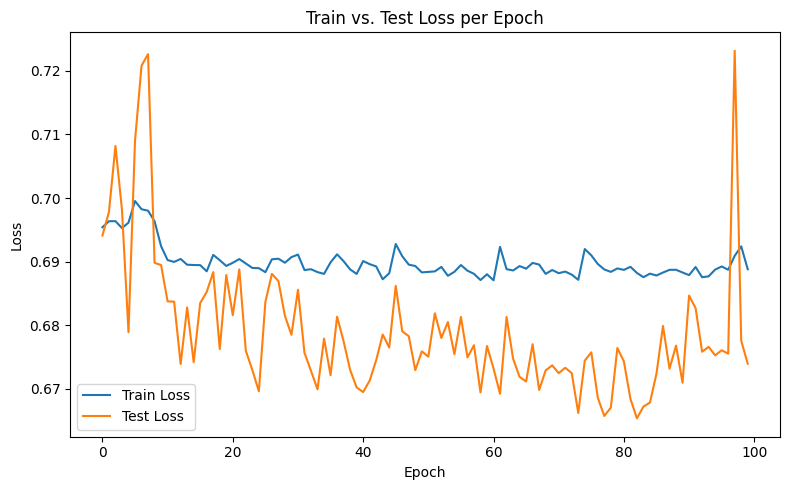

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6963
[Epoch 10/100]  Train Loss: 0.6939
[Epoch 15/100]  Train Loss: 0.6918
[Epoch 20/100]  Train Loss: 0.6907
[Epoch 25/100]  Train Loss: 0.6892
[Epoch 30/100]  Train Loss: 0.6891
[Epoch 35/100]  Train Loss: 0.6873
[Epoch 40/100]  Train Loss: 0.6875
[Epoch 45/100]  Train Loss: 0.6866
[Epoch 50/100]  Train Loss: 0.6872
[Epoch 55/100]  Train Loss: 0.6847
[Epoch 60/100]  Train Loss: 0.6848
[Epoch 65/100]  Train Loss: 0.6822
[Epoch 70/100]  Train Loss: 0.6835
[Epoch 75/100]  Train Loss: 0.6823
[Epoch 80/100]  Train Loss: 0.6842
[Epoch 85/100]  Train Loss: 0.6832
[Epoch 90/100]  Train Loss: 0.6842
[Epoch 95/100]  Train Loss: 0.6837
[Epoch 100/100]  Train Loss: 0.6825
Accuracy on Nonzero Predictions: 0.5733


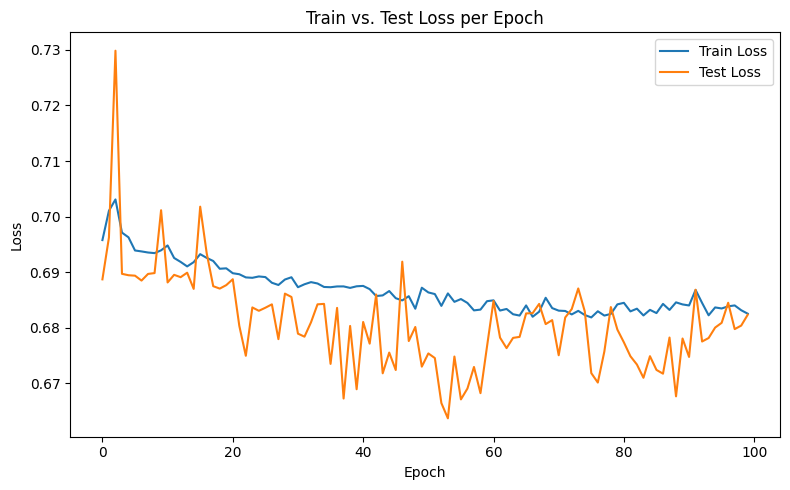

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6951
[Epoch 10/100]  Train Loss: 0.6912
[Epoch 15/100]  Train Loss: 0.6899
[Epoch 20/100]  Train Loss: 0.6886
[Epoch 25/100]  Train Loss: 0.6915
[Epoch 30/100]  Train Loss: 0.6889
[Epoch 35/100]  Train Loss: 0.6887
[Epoch 40/100]  Train Loss: 0.6879
[Epoch 45/100]  Train Loss: 0.6873
[Epoch 50/100]  Train Loss: 0.6893
[Epoch 55/100]  Train Loss: 0.6882
[Epoch 60/100]  Train Loss: 0.6866
[Epoch 65/100]  Train Loss: 0.6858
[Epoch 70/100]  Train Loss: 0.6846
[Epoch 75/100]  Train Loss: 0.6859
[Epoch 80/100]  Train Loss: 0.6865
[Epoch 85/100]  Train Loss: 0.6862
[Epoch 90/100]  Train Loss: 0.6850
[Epoch 95/100]  Train Loss: 0.6855
[Epoch 100/100]  Train Loss: 0.6855
Accuracy on Nonzero Predictions: 0.6167


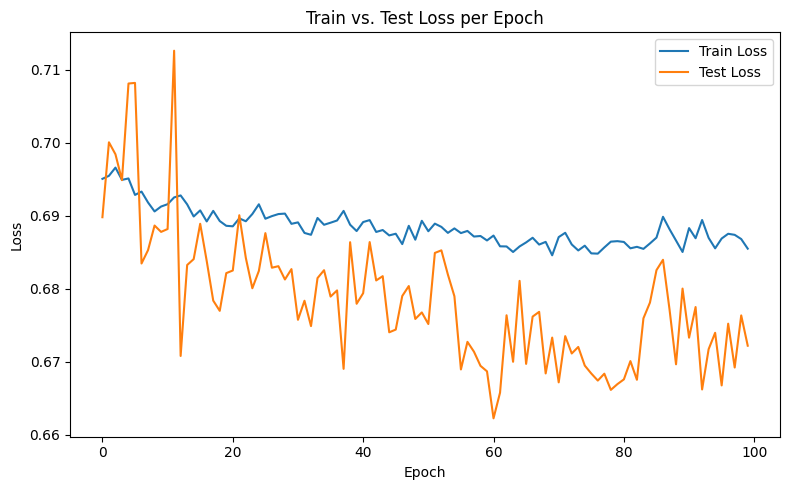

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6951
[Epoch 10/100]  Train Loss: 0.6902
[Epoch 15/100]  Train Loss: 0.6876
[Epoch 20/100]  Train Loss: 0.6863
[Epoch 25/100]  Train Loss: 0.6835
[Epoch 30/100]  Train Loss: 0.6850
[Epoch 35/100]  Train Loss: 0.6791
[Epoch 40/100]  Train Loss: 0.6795
[Epoch 45/100]  Train Loss: 0.6788
[Epoch 50/100]  Train Loss: 0.6740
[Epoch 55/100]  Train Loss: 0.6775
[Epoch 60/100]  Train Loss: 0.6710
[Epoch 65/100]  Train Loss: 0.6727
[Epoch 70/100]  Train Loss: 0.6768
[Epoch 75/100]  Train Loss: 0.6766
[Epoch 80/100]  Train Loss: 0.6690
[Epoch 85/100]  Train Loss: 0.6676
[Epoch 90/100]  Train Loss: 0.6661
[Epoch 95/100]  Train Loss: 0.6635
[Epoch 100/100]  Train Loss: 0.6668
Accuracy on Nonzero Predictions: 0.5133


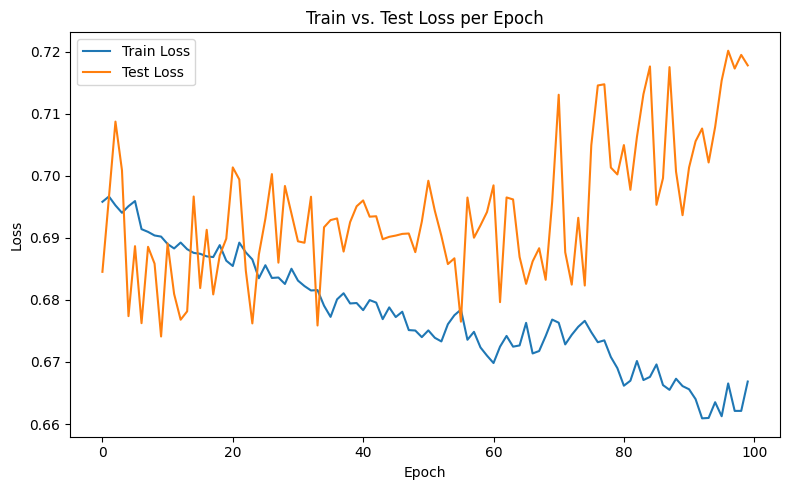

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6958
[Epoch 10/100]  Train Loss: 0.6918
[Epoch 15/100]  Train Loss: 0.6896
[Epoch 20/100]  Train Loss: 0.6902
[Epoch 25/100]  Train Loss: 0.6905
[Epoch 30/100]  Train Loss: 0.6885
[Epoch 35/100]  Train Loss: 0.6889
[Epoch 40/100]  Train Loss: 0.6884
[Epoch 45/100]  Train Loss: 0.6896
[Epoch 50/100]  Train Loss: 0.6876
[Epoch 55/100]  Train Loss: 0.6866
[Epoch 60/100]  Train Loss: 0.6873
[Epoch 65/100]  Train Loss: 0.6857
[Epoch 70/100]  Train Loss: 0.6866
[Epoch 75/100]  Train Loss: 0.6855
[Epoch 80/100]  Train Loss: 0.6852
[Epoch 85/100]  Train Loss: 0.6832
[Epoch 90/100]  Train Loss: 0.6835
[Epoch 95/100]  Train Loss: 0.6829
[Epoch 100/100]  Train Loss: 0.6839
Accuracy on Nonzero Predictions: 0.6067


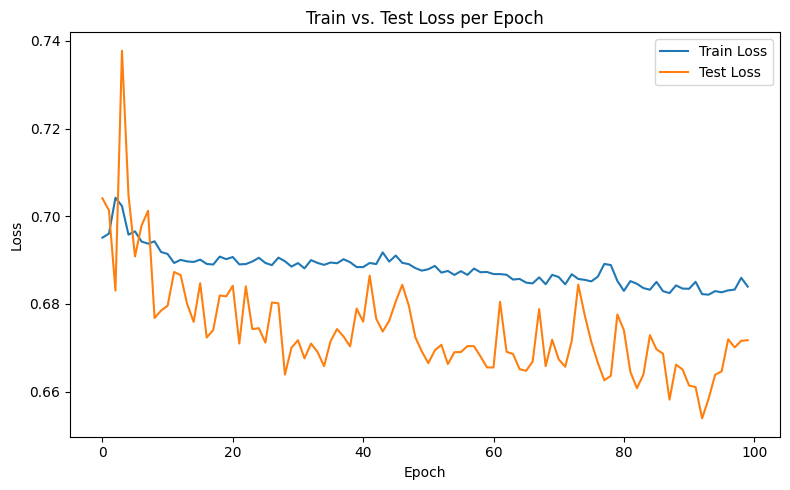

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6947
[Epoch 10/100]  Train Loss: 0.6913
[Epoch 15/100]  Train Loss: 0.6871
[Epoch 20/100]  Train Loss: 0.6858
[Epoch 25/100]  Train Loss: 0.6854
[Epoch 30/100]  Train Loss: 0.6882
[Epoch 35/100]  Train Loss: 0.6809
[Epoch 40/100]  Train Loss: 0.6844
[Epoch 45/100]  Train Loss: 0.6842
[Epoch 50/100]  Train Loss: 0.6808
[Epoch 55/100]  Train Loss: 0.6825
[Epoch 60/100]  Train Loss: 0.6816
[Epoch 65/100]  Train Loss: 0.6875
[Epoch 70/100]  Train Loss: 0.6854
[Epoch 75/100]  Train Loss: 0.6894
[Epoch 80/100]  Train Loss: 0.6855
[Epoch 85/100]  Train Loss: 0.6878
[Epoch 90/100]  Train Loss: 0.6851
[Epoch 95/100]  Train Loss: 0.6819
[Epoch 100/100]  Train Loss: 0.6844
Accuracy on Nonzero Predictions: 0.5433


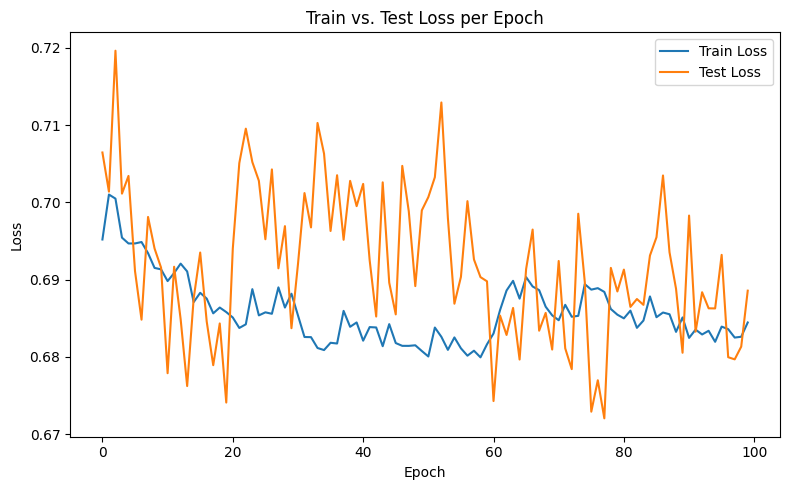

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6954
[Epoch 10/100]  Train Loss: 0.6920
[Epoch 15/100]  Train Loss: 0.6911
[Epoch 20/100]  Train Loss: 0.6901
[Epoch 25/100]  Train Loss: 0.6873
[Epoch 30/100]  Train Loss: 0.6872
[Epoch 35/100]  Train Loss: 0.6865
[Epoch 40/100]  Train Loss: 0.6867
[Epoch 45/100]  Train Loss: 0.6856
[Epoch 50/100]  Train Loss: 0.6854
[Epoch 55/100]  Train Loss: 0.6849
[Epoch 60/100]  Train Loss: 0.6841
[Epoch 65/100]  Train Loss: 0.6836
[Epoch 70/100]  Train Loss: 0.6827
[Epoch 75/100]  Train Loss: 0.6848
[Epoch 80/100]  Train Loss: 0.6810
[Epoch 85/100]  Train Loss: 0.6800
[Epoch 90/100]  Train Loss: 0.6805
[Epoch 95/100]  Train Loss: 0.6808
[Epoch 100/100]  Train Loss: 0.6798
Accuracy on Nonzero Predictions: 0.5867


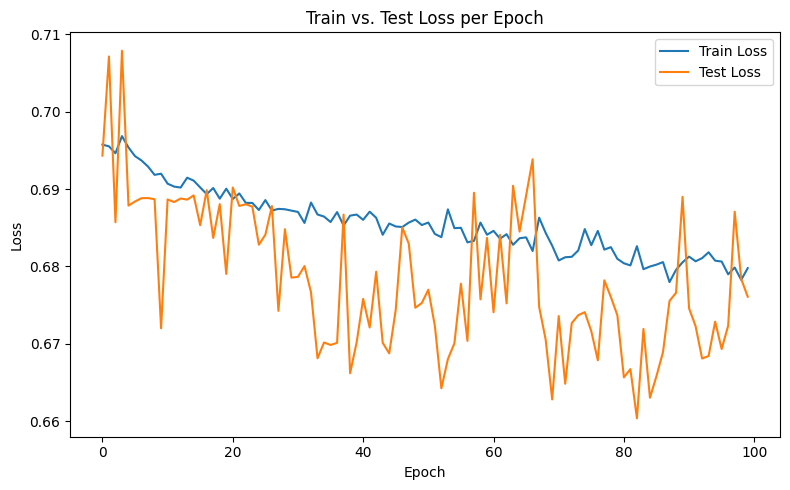

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7003
[Epoch 10/100]  Train Loss: 0.6932
[Epoch 15/100]  Train Loss: 0.6944
[Epoch 20/100]  Train Loss: 0.6924
[Epoch 25/100]  Train Loss: 0.6907
[Epoch 30/100]  Train Loss: 0.6909
[Epoch 35/100]  Train Loss: 0.6885
[Epoch 40/100]  Train Loss: 0.6877
[Epoch 45/100]  Train Loss: 0.6872
[Epoch 50/100]  Train Loss: 0.6900
[Epoch 55/100]  Train Loss: 0.6883
[Epoch 60/100]  Train Loss: 0.6873
[Epoch 65/100]  Train Loss: 0.6882
[Epoch 70/100]  Train Loss: 0.6893
[Epoch 75/100]  Train Loss: 0.6872
[Epoch 80/100]  Train Loss: 0.6913
[Epoch 85/100]  Train Loss: 0.6884
[Epoch 90/100]  Train Loss: 0.6883
[Epoch 95/100]  Train Loss: 0.6884
[Epoch 100/100]  Train Loss: 0.6879
Accuracy on Nonzero Predictions: 0.6067


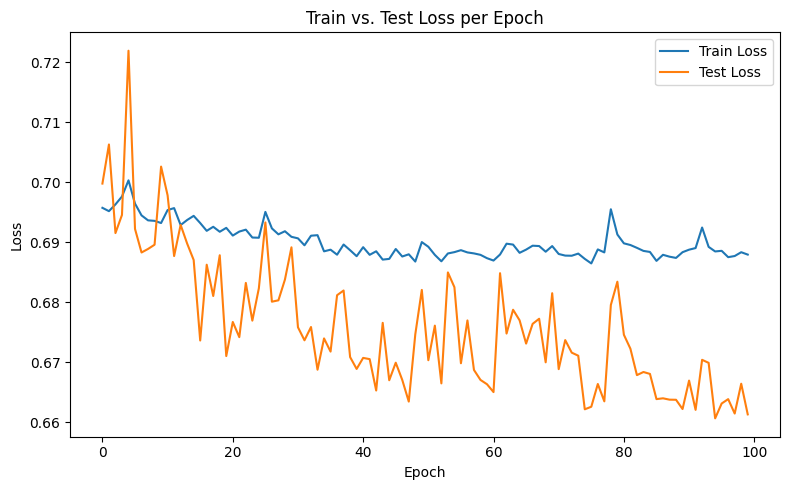

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6935
[Epoch 10/100]  Train Loss: 0.6909
[Epoch 15/100]  Train Loss: 0.6899
[Epoch 20/100]  Train Loss: 0.6895
[Epoch 25/100]  Train Loss: 0.6893
[Epoch 30/100]  Train Loss: 0.6871
[Epoch 35/100]  Train Loss: 0.6876
[Epoch 40/100]  Train Loss: 0.6874
[Epoch 45/100]  Train Loss: 0.6891
[Epoch 50/100]  Train Loss: 0.6855
[Epoch 55/100]  Train Loss: 0.6835
[Epoch 60/100]  Train Loss: 0.6855
[Epoch 65/100]  Train Loss: 0.6825
[Epoch 70/100]  Train Loss: 0.6804
[Epoch 75/100]  Train Loss: 0.6784
[Epoch 80/100]  Train Loss: 0.6802
[Epoch 85/100]  Train Loss: 0.6781
[Epoch 90/100]  Train Loss: 0.6799
[Epoch 95/100]  Train Loss: 0.6756
[Epoch 100/100]  Train Loss: 0.6760
Accuracy on Nonzero Predictions: 0.5967


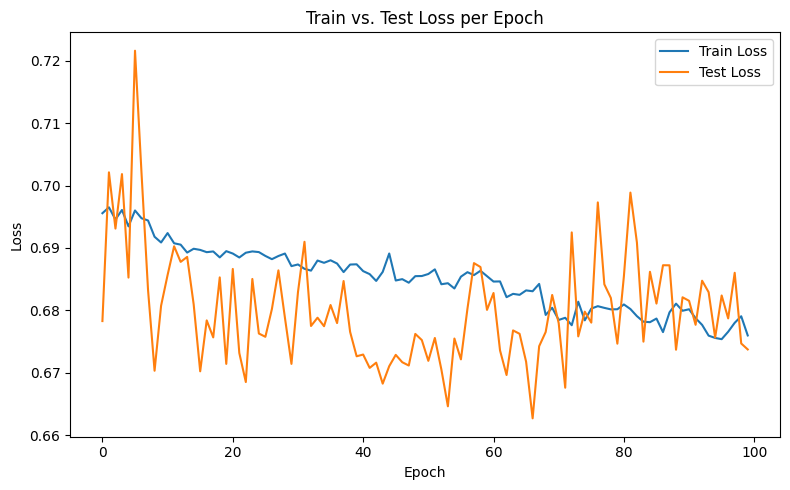

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6945
[Epoch 10/100]  Train Loss: 0.6938
[Epoch 15/100]  Train Loss: 0.6929
[Epoch 20/100]  Train Loss: 0.6913
[Epoch 25/100]  Train Loss: 0.6903
[Epoch 30/100]  Train Loss: 0.6910
[Epoch 35/100]  Train Loss: 0.6897
[Epoch 40/100]  Train Loss: 0.6893
[Epoch 45/100]  Train Loss: 0.6886
[Epoch 50/100]  Train Loss: 0.6881
[Epoch 55/100]  Train Loss: 0.6901
[Epoch 60/100]  Train Loss: 0.6889
[Epoch 65/100]  Train Loss: 0.6882
[Epoch 70/100]  Train Loss: 0.6893
[Epoch 75/100]  Train Loss: 0.6890
[Epoch 80/100]  Train Loss: 0.6890
[Epoch 85/100]  Train Loss: 0.6898
[Epoch 90/100]  Train Loss: 0.6902
[Epoch 95/100]  Train Loss: 0.6894
[Epoch 100/100]  Train Loss: 0.6886
Accuracy on Nonzero Predictions: 0.6100


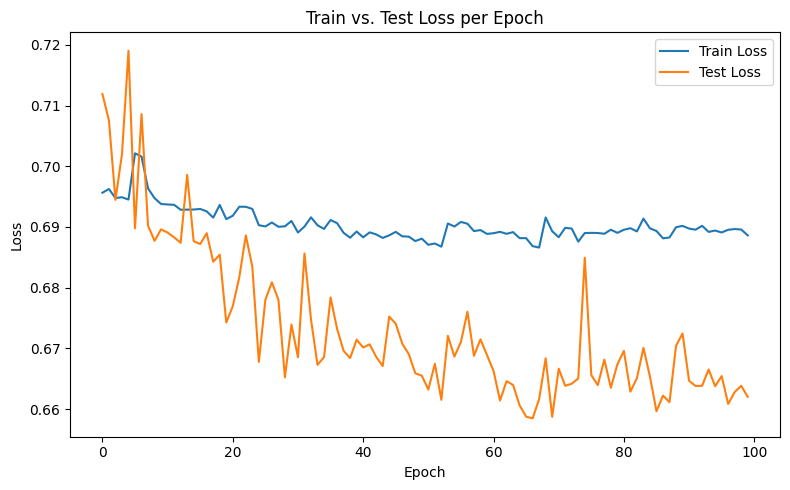

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7038
[Epoch 10/100]  Train Loss: 0.6980
[Epoch 15/100]  Train Loss: 0.6958
[Epoch 20/100]  Train Loss: 0.6942
[Epoch 25/100]  Train Loss: 0.6935
[Epoch 30/100]  Train Loss: 0.6922
[Epoch 35/100]  Train Loss: 0.6907
[Epoch 40/100]  Train Loss: 0.6889
[Epoch 45/100]  Train Loss: 0.6873
[Epoch 50/100]  Train Loss: 0.6870
[Epoch 55/100]  Train Loss: 0.6884
[Epoch 60/100]  Train Loss: 0.6856
[Epoch 65/100]  Train Loss: 0.6854
[Epoch 70/100]  Train Loss: 0.6848
[Epoch 75/100]  Train Loss: 0.6849
[Epoch 80/100]  Train Loss: 0.6835
[Epoch 85/100]  Train Loss: 0.6831
[Epoch 90/100]  Train Loss: 0.6839
[Epoch 95/100]  Train Loss: 0.6835
[Epoch 100/100]  Train Loss: 0.6831
Accuracy on Nonzero Predictions: 0.5933


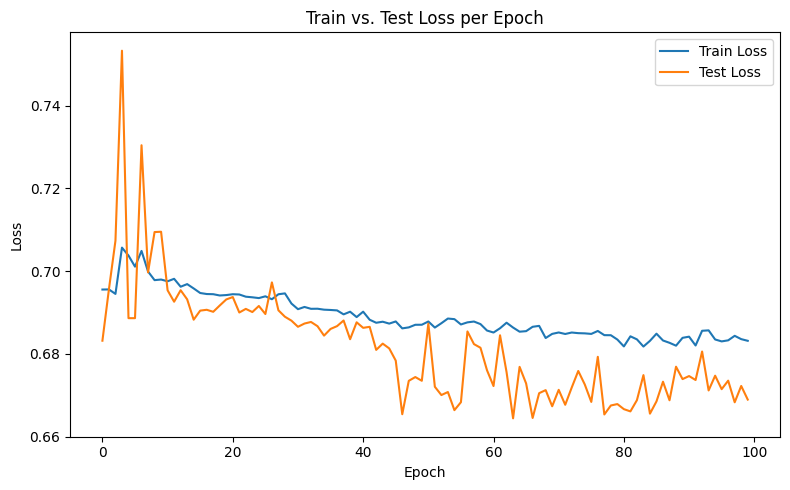

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6976
[Epoch 10/100]  Train Loss: 0.6930
[Epoch 15/100]  Train Loss: 0.6925
[Epoch 20/100]  Train Loss: 0.6890
[Epoch 25/100]  Train Loss: 0.6873
[Epoch 30/100]  Train Loss: 0.6883
[Epoch 35/100]  Train Loss: 0.6883
[Epoch 40/100]  Train Loss: 0.6881
[Epoch 45/100]  Train Loss: 0.6879
[Epoch 50/100]  Train Loss: 0.6904
[Epoch 55/100]  Train Loss: 0.6895
[Epoch 60/100]  Train Loss: 0.6869
[Epoch 65/100]  Train Loss: 0.6863
[Epoch 70/100]  Train Loss: 0.6867
[Epoch 75/100]  Train Loss: 0.6862
[Epoch 80/100]  Train Loss: 0.6854
[Epoch 85/100]  Train Loss: 0.6855
[Epoch 90/100]  Train Loss: 0.6845
[Epoch 95/100]  Train Loss: 0.6860
[Epoch 100/100]  Train Loss: 0.6841
Accuracy on Nonzero Predictions: 0.5933


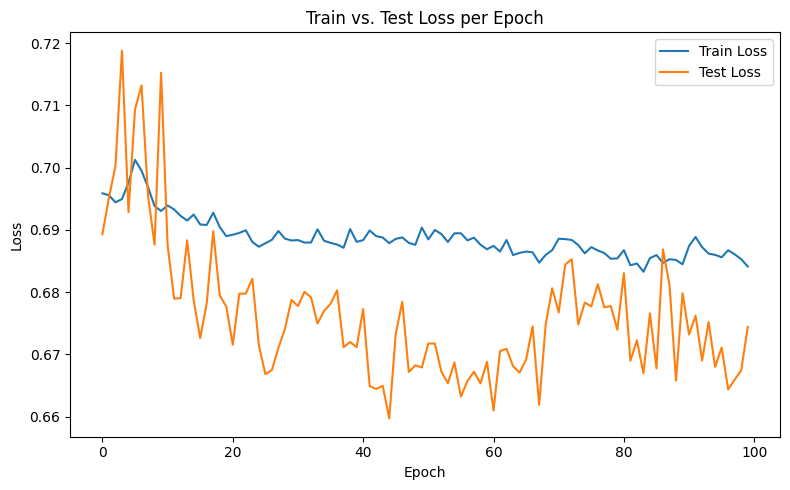

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6949
[Epoch 10/100]  Train Loss: 0.6922
[Epoch 15/100]  Train Loss: 0.6894
[Epoch 20/100]  Train Loss: 0.6895
[Epoch 25/100]  Train Loss: 0.6871
[Epoch 30/100]  Train Loss: 0.6880
[Epoch 35/100]  Train Loss: 0.6894
[Epoch 40/100]  Train Loss: 0.6898
[Epoch 45/100]  Train Loss: 0.6864
[Epoch 50/100]  Train Loss: 0.6885
[Epoch 55/100]  Train Loss: 0.6865
[Epoch 60/100]  Train Loss: 0.6862
[Epoch 65/100]  Train Loss: 0.6876
[Epoch 70/100]  Train Loss: 0.6872
[Epoch 75/100]  Train Loss: 0.6857
[Epoch 80/100]  Train Loss: 0.6832
[Epoch 85/100]  Train Loss: 0.6884
[Epoch 90/100]  Train Loss: 0.6834
[Epoch 95/100]  Train Loss: 0.6837
[Epoch 100/100]  Train Loss: 0.6806
Accuracy on Nonzero Predictions: 0.5500


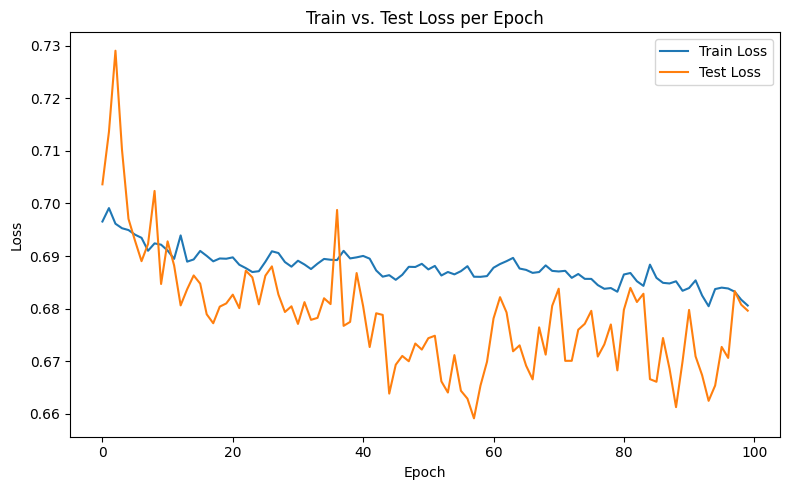

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6987
[Epoch 10/100]  Train Loss: 0.6913
[Epoch 15/100]  Train Loss: 0.6899
[Epoch 20/100]  Train Loss: 0.6885
[Epoch 25/100]  Train Loss: 0.6889
[Epoch 30/100]  Train Loss: 0.6865
[Epoch 35/100]  Train Loss: 0.6866
[Epoch 40/100]  Train Loss: 0.6845
[Epoch 45/100]  Train Loss: 0.6836
[Epoch 50/100]  Train Loss: 0.6853
[Epoch 55/100]  Train Loss: 0.6809
[Epoch 60/100]  Train Loss: 0.6815
[Epoch 65/100]  Train Loss: 0.6830
[Epoch 70/100]  Train Loss: 0.6803
[Epoch 75/100]  Train Loss: 0.6843
[Epoch 80/100]  Train Loss: 0.6819
[Epoch 85/100]  Train Loss: 0.6796
[Epoch 90/100]  Train Loss: 0.6786
[Epoch 95/100]  Train Loss: 0.6773
[Epoch 100/100]  Train Loss: 0.6856
Accuracy on Nonzero Predictions: 0.5433


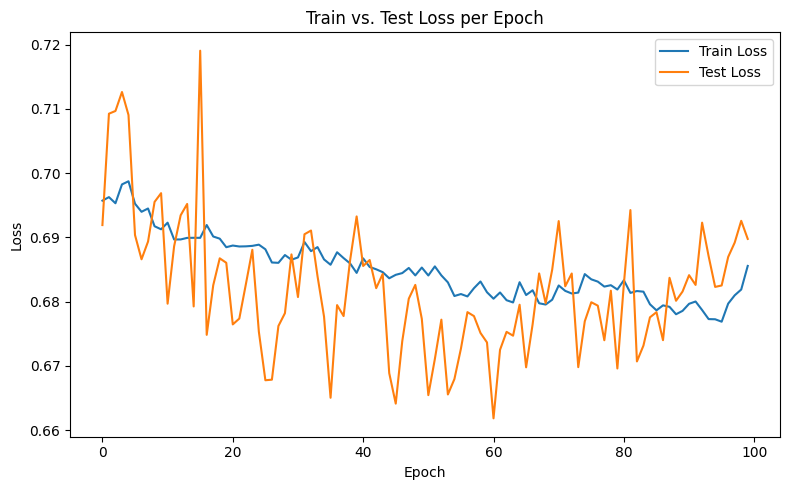

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6947
[Epoch 10/100]  Train Loss: 0.6909
[Epoch 15/100]  Train Loss: 0.6904
[Epoch 20/100]  Train Loss: 0.6884
[Epoch 25/100]  Train Loss: 0.6872
[Epoch 30/100]  Train Loss: 0.6895
[Epoch 35/100]  Train Loss: 0.6880
[Epoch 40/100]  Train Loss: 0.6870
[Epoch 45/100]  Train Loss: 0.6883
[Epoch 50/100]  Train Loss: 0.6902
[Epoch 55/100]  Train Loss: 0.6879
[Epoch 60/100]  Train Loss: 0.6876
[Epoch 65/100]  Train Loss: 0.6882
[Epoch 70/100]  Train Loss: 0.6899
[Epoch 75/100]  Train Loss: 0.6897
[Epoch 80/100]  Train Loss: 0.6873
[Epoch 85/100]  Train Loss: 0.6869
[Epoch 90/100]  Train Loss: 0.6908
[Epoch 95/100]  Train Loss: 0.6905
[Epoch 100/100]  Train Loss: 0.6900
Accuracy on Nonzero Predictions: 0.5767


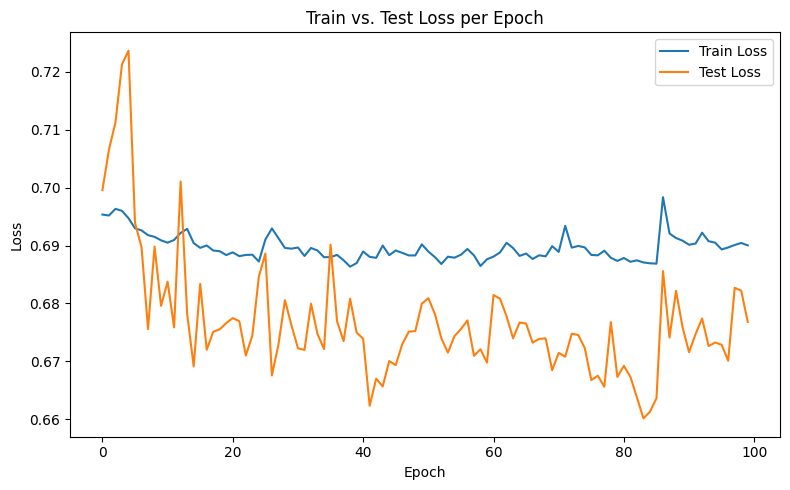

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6994
[Epoch 10/100]  Train Loss: 0.6910
[Epoch 15/100]  Train Loss: 0.6908
[Epoch 20/100]  Train Loss: 0.6900
[Epoch 25/100]  Train Loss: 0.6889
[Epoch 30/100]  Train Loss: 0.6884
[Epoch 35/100]  Train Loss: 0.6889
[Epoch 40/100]  Train Loss: 0.6864
[Epoch 45/100]  Train Loss: 0.6851
[Epoch 50/100]  Train Loss: 0.6849
[Epoch 55/100]  Train Loss: 0.6847
[Epoch 60/100]  Train Loss: 0.6825
[Epoch 65/100]  Train Loss: 0.6797
[Epoch 70/100]  Train Loss: 0.6794
[Epoch 75/100]  Train Loss: 0.6822
[Epoch 80/100]  Train Loss: 0.6812
[Epoch 85/100]  Train Loss: 0.6838
[Epoch 90/100]  Train Loss: 0.6812
[Epoch 95/100]  Train Loss: 0.6799
[Epoch 100/100]  Train Loss: 0.6812
Accuracy on Nonzero Predictions: 0.6133


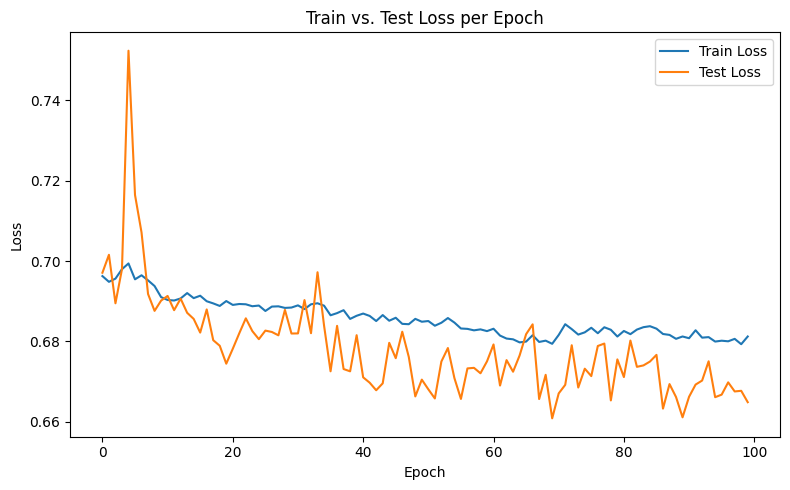

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6941
[Epoch 10/100]  Train Loss: 0.6895
[Epoch 15/100]  Train Loss: 0.6898
[Epoch 20/100]  Train Loss: 0.6883
[Epoch 25/100]  Train Loss: 0.6877
[Epoch 30/100]  Train Loss: 0.6874
[Epoch 35/100]  Train Loss: 0.6882
[Epoch 40/100]  Train Loss: 0.6875
[Epoch 45/100]  Train Loss: 0.6875
[Epoch 50/100]  Train Loss: 0.6843
[Epoch 55/100]  Train Loss: 0.6857
[Epoch 60/100]  Train Loss: 0.6857
[Epoch 65/100]  Train Loss: 0.6867
[Epoch 70/100]  Train Loss: 0.6824
[Epoch 75/100]  Train Loss: 0.6839
[Epoch 80/100]  Train Loss: 0.6839
[Epoch 85/100]  Train Loss: 0.6860
[Epoch 90/100]  Train Loss: 0.6877
[Epoch 95/100]  Train Loss: 0.6833
[Epoch 100/100]  Train Loss: 0.6859
Accuracy on Nonzero Predictions: 0.6067


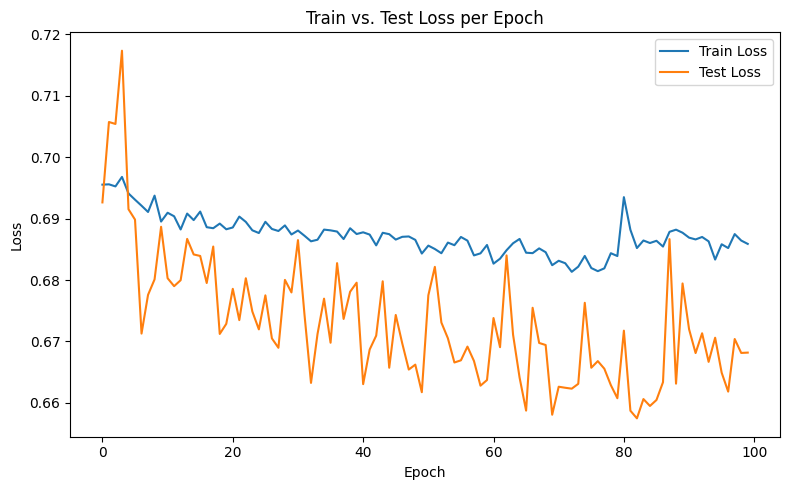

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png


In [12]:
model_types = ["gru"]   
sample_size = 50
window_sizes = [5]
test_size = 300

results_list = []

for window_size in window_sizes:
    
    initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

    # 1) Load original data (info only)
    filename = f"{security_type}/{stock}/{period}_data.csv"
    original_input_filepath = os.path.join(initial_data_dir, filename)
    original_data = pd.read_csv(original_input_filepath)

    print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

    # 2) Load the preprocessed data
    pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
    input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
    input_df = pd.read_pickle(input_filepath)

    # 3) Reshape
    X_combined, y_combined = reshape_remove_characters(input_df)
    
    # X_combined, y_combined = combine_stocks_pkl_new_df(processing, security_type, period, window_size, project_dir, stocks, test_size)
    input_size = X_combined.shape[2]
    # train_size = int(X_combined.shape[0] * possible_train_size / 100)
    train_size = X_combined.shape[0] - test_size
    # test_size = X_combined.shape[0] - train_size

    for model_type in model_types:
        for i in range(sample_size):
            if model_type == "gru":
                model = GRU3DClassifier(input_size, hidden_size, output_size, num_layers, dropout)
            elif model_type == "lstm":
                model = StockPriceLSTM(input_size, hidden_size, output_size)

            model = model.to(device)

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            print(f"Training {stocks[-1]} | LR: {learning_rate} | Epochs: {num_epochs} "
                  f"| Batch: {batch_size} | Security type: {security_type}")


            result = evaluate_model_plot(
                model, 
                X_combined, 
                y_combined, 
                criterion, 
                optimizer, 
                device, 
                train_size, 
                batch_size, 
                num_epochs, 
                lower_threshold = 0.5,
                plots_dir=plots_dir,
                plot_filename=None
            )

            # Store results in a list
            results_list.append({
                "security_type": security_type,
                "window_size": window_size,
                "model_type": model_type,
                "iteration": i + 1,
                "accuracy_nonzero": result["accuracy_nonzero"],
                "loss_decrease_percentage": result["loss_decrease_percentage"],
                "final_train_loss": result["final_train_loss"]
            })

results_df = pd.DataFrame(results_list)

In [15]:
output_folder = os.path.join(results_dir, 'best_models')

results_df.to_csv(os.path.join(output_folder, f'combined_{window_size}_{security_type}_{model_type}.csv'), index=False)

In [14]:
results_df

,security_type,window_size,model_type,iteration,accuracy_nonzero,loss_decrease_percentage,final_train_loss
0,options,5,gru,1,0.620000,-1.565402,0.684805
1,options,5,gru,2,0.593333,-1.757080,0.683496
2,options,5,gru,3,0.470000,-2.214687,0.679911
3,options,5,gru,4,0.603333,-1.450839,0.685892
4,options,5,gru,5,0.606667,-2.098234,0.680806
5,options,5,gru,6,0.593333,-1.409761,0.685553
6,options,5,gru,7,0.590000,-1.253848,0.686999
7,options,5,gru,8,0.586667,-1.760590,0.683189
8,options,5,gru,9,0.606667,-1.417386,0.685301
9,options,5,gru,10,0.603333,-0.821862,0.690200
